In [2]:
import pandas as pd
import os
import numpy as np
from keras.preprocessing import timeseries_dataset_from_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import timeseries_dataset_from_array
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

2024-12-07 00:28:33.678073: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
class DataPreprocess:
    def __init__(self):
        pass

    def load_data(self, path):
        df = pd.read_csv(path)
        df.drop("Unnamed: 0", inplace=True, axis = 1)
        return df

    def get_bid_levels(self, df, bid_levels):
        df_tmp = pd.DataFrame()
        df_tmp['time'] = pd.to_datetime(df['system_time'])
        df_tmp['midpoint'] = df['midpoint']
        
        # Filter ask and bid volume columns
        ask_cols = [f'asks_limit_notional_{i}' for i in range(bid_levels)]
        bid_cols = [f'bids_limit_notional_{i}' for i in range(bid_levels)]
        ask_cols = [col for col in ask_cols if col in df.columns]
        bid_cols = [col for col in bid_cols if col in df.columns]
        
        # Assign ask and bid volumes
        for lvls in range(len(ask_cols)):  # Use the length of filtered columns
            df_tmp[f'ask_volume{lvls}'] = df[ask_cols[lvls]]
        for lvls in range(len(bid_cols)):  # Use the length of filtered columns
            df_tmp[f'bid_volume{lvls}'] = df[bid_cols[lvls]]
        
        # Filter ask and bid distance columns
        ask_distance_cols = [f'asks_distance_{i}' for i in range(bid_levels)]
        bid_distance_cols = [f'bids_distance_{i}' for i in range(bid_levels)]
        ask_distance_cols = [col for col in ask_distance_cols if col in df.columns]
        bid_distance_cols = [col for col in bid_distance_cols if col in df.columns]
        
        # Assign ask and bid prices
        for lvls in range(len(ask_distance_cols)):  # Use the length of filtered columns
            df_tmp[f'ask_price{lvls}'] = df['midpoint'] + (df['midpoint'] * df[ask_distance_cols[lvls]])
        for lvls in range(len(bid_distance_cols)):  # Use the length of filtered columns
            df_tmp[f'bid_price{lvls}'] = df['midpoint'] + (df['midpoint'] * df[bid_distance_cols[lvls]])
        return df_tmp

    """
        For a actively traded stock,
        1. If there is an increase in the bid price in future compared to its current or previous value.
            We take the Bid volume.
        2. If the previous and current price is same we take the difference in the volume.
        3. If the current price is less than the current one then we take -ve of the current volume.

        Order Flow Imbalance is actually a factor that denotes the buying side or selling pressue for a particular stock at that level.
        When OFI > 0 it means that market is dominated by sellers. Lot more bids have happened.
        When OFI < 0 it means that market is dominated by buyers. Lot more asks have happened.
    """
    def get_bid_with_ofi_levels(self, df_tmp, bid_levels):
        for lvls in range(bid_levels):
            bid_price = df_tmp[f'bid_price{lvls}']
            ask_price = df_tmp[f'ask_price{lvls}']
            bid_volume = df_tmp[f'bid_volume{lvls}']
            ask_volume = df_tmp[f'ask_volume{lvls}']
            
            # Shift prices and volumes to compute differences
            bid_price_prev = bid_price.shift(1)
            ask_price_prev = ask_price.shift(1)
            bid_volume_prev = bid_volume.shift(1)
            ask_volume_prev = ask_volume.shift(1)
            
            # Calculate bid and ask order flows
            bid_of = np.where(
                bid_price > bid_price_prev, bid_volume,
                np.where(bid_price == bid_price_prev, bid_volume - bid_volume_prev, -bid_volume)
            )
            ask_of = np.where(
                ask_price > ask_price_prev, -ask_volume,
                np.where(ask_price == ask_price_prev, ask_volume - ask_volume_prev, ask_volume)
            )
            
            # Calculate OFI
            df_tmp[f'ofi_level{lvls}'] = bid_of - ask_of
        return df_tmp

    
    def make_window(self, window_size, dataframe, partition):
        normalized_df = df_new.to_numpy()
        dataframe.drop("time", inplace=True, axis = 1)
        train_length = int(len(normalized_df) * partition)
        data_length = len(normalized_df)
        
        midpoint_idx = df_new.columns.get_loc("midpoint")
        
        windows_train = timeseries_dataset_from_array(
            normalized_df[:train_length],  # Features for training
            normalized_df[window_size:train_length + window_size, midpoint_idx],  # Labels for training
            window_size,
            sequence_stride=1,
            sampling_rate=1,
            batch_size=64,
            shuffle=False,
            seed=None
        )
        
        # Windows for test dataset
        windows_test = timeseries_dataset_from_array(
            normalized_df[train_length:data_length - window_size],  # Features for testing
            normalized_df[train_length + window_size:, midpoint_idx],  # Labels for testing
            window_size,
            sequence_stride=1,
            sampling_rate=1,
            batch_size=64,
            shuffle=False
        )
        return windows_train, windows_test

    """
        Returns x_train, y_train, x_test, y_test
    """
    def make_generic_window(self, window_size, df, partition, make_window=False):
        feature_columns = [col for col in df.columns if col != 'midpoint' and col != 'time']
        X, y = [], []

        if make_window:
            # Create sliding windows
            for i in range(len(df) - window_size):
                X.append(df.iloc[i:i + window_size][feature_columns].values)
                y.append(df.iloc[i + window_size]['midpoint'])
            
            X = np.array(X)
            y = np.array(y)
            split_point = int(len(df)*partition)
            X_train = X[:split_point]
            X_test = X[split_point:]
            y_train = df.iloc[:split_point]['midpoint']
            y_test =  df.iloc[split_point:]['midpoint']
            return X_train, X_test, y_train, y_test
        else:
            split_point = int(len(df)*partition)
            X_train = X[:split_point]
            X_test = X[split_point:]
            y_train = df.iloc[:split_point]['midpoint']
            y_test =  df.iloc[split_point:]['midpoint']
            
            return X_train, X_test, y_train, y_test

    def normalize_data(self, df, train_length):
        """
        Normalizes data based on the training dataset mean and std.
        """
        if "time" in df.columns:
            df = df.drop(columns=["time"])
        mean_df = df[:train_length].mean()
        std_df = df[:train_length].std()
        normalized_df = (df - mean_df) / std_df
        return normalized_df

    # Function to extract data from TensorFlow Dataset
    def extract_data_from_dataset(self, dataset):
        X_list = []
        y_list = []
        for X_batch, y_batch in dataset:
            X_list.append(X_batch.numpy())
            y_list.append(y_batch.numpy())
        X_array = np.vstack(X_list)  # Combine batches into one array
        y_array = np.concatenate(y_list)
        return X_array, y_array

    def r_get_window(self, normalized_df, df_tmp, train_length, window_size):
        # Drop time column (not needed for input features)
        df_tmp = df_tmp.drop(columns=["time"])
        
        # Split dataset into train and test sets
        data_length = df_tmp.shape[0]
        train_length = round(0.8 * data_length)  # 80% training data
        
        normalized_df = dp.normalize_data(df_tmp, train_length)

        data_array = normalized_df.to_numpy()
        
        X = data_array[:, 1:]  # All columns except the first ('midpoint')
        y = df_tmp["midpoint"]
        #y = data_array[:, 0]   # The first column is 'midpoint'
        
        windows_train = timeseries_dataset_from_array(
            X[:train_length],                    # Features for training
            y[window_size:(train_length+window_size)],  # Target (midpoint) for training
            sequence_length=window_size,        # Length of each input sequence
            sequence_stride=1,                  # Step size for creating sequences
            sampling_rate=1,                    # Sample every time step
            batch_size=64,                      # Batch size
            shuffle=False                        # Shuffle training data
        )
        
        # Windows for test dataset
        windows_test = timeseries_dataset_from_array(
            X[train_length:(data_length-window_size)],  # Features for testing
            y[train_length + window_size:],            # Target (midpoint) for testing
            sequence_length=window_size,               # Length of each input sequence
            sequence_stride=1,                         # Step size for creating sequences
            sampling_rate=1,                           # Sample every time step
            batch_size=64,                             # Batch size
            shuffle=False                              # Do not shuffle test data
        )
        
        return windows_train, windows_test

    # Function to extract data from TensorFlow Dataset
    def extract_data_from_dataset(self, dataset):
        X_list = []
        y_list = []
        for X_batch, y_batch in dataset:
            X_list.append(X_batch.numpy())
            y_list.append(y_batch.numpy())
        X_array = np.vstack(X_list)  # Combine batches into one array
        y_array = np.concatenate(y_list)
        return X_array, y_array

    def plot_graph(self, y_test, y_pred):
        # Plotting the graphs
        plt.figure(figsize=(10, 6))
        plt.plot(y_test, label="Actual", color="blue")
        plt.plot(y_pred, label="Predicted", color="red", linestyle="--")
        plt.legend()
        plt.title("Actual vs Predicted Values")
        plt.xlabel("Sample Index")
        plt.ylabel("Target Value")
        plt.show()

    def get_metrics(self, y_test, y_pred):
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        print(f"Mean Squared Error: {mse}")
        print(f"R² Score: {r2}")
        
        dp.plot_graph(y_test, y_pred)

In [4]:
dp = DataPreprocess()

df = dp.load_data('archive/ETH_1min.csv')

In [5]:
def train_model_and_get_result(lvls, window_size, no_of_neighbours=5, is_ofi=True):
    df_one = dp.get_bid_levels(df, lvls)
    df_one.head()
    
    if is_ofi:
        df_one = dp.get_bid_with_ofi_levels(df_one, lvls)
        
    data_length = df_one.shape[0]
    train_length = round(0.8*data_length)
    
    normalized_df = dp.normalize_data(df_one, train_length)
    windows_train, windows_test = dp.r_get_window(normalized_df, df_one, train_length, window_size)
    
    # Extract training data
    X_train, y_train = dp.extract_data_from_dataset(windows_train)
    
    # Extract testing data
    X_test, y_test = dp.extract_data_from_dataset(windows_test)
    
    
    # Flatten training and testing data
    X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Flatten each window
    X_test_flat = X_test.reshape(X_test.shape[0], -1)
    
    # Initialize scaler
    scaler = StandardScaler()
    
    # Fit and transform training data
    X_train_scaled = scaler.fit_transform(X_train_flat)
    
    # Transform testing data
    X_test_scaled = scaler.transform(X_test_flat)
    
    
    knn = KNeighborsRegressor(n_neighbors=8)
    
    knn.fit(X_train_scaled, y_train)

    y_pred = knn.predict(X_test_scaled)
    dp.get_metrics(y_test, y_pred)

metrics for  lvl -  3 window -  25 no_of_neighbours -  5 ofi -  True


2024-12-07 00:28:39.683356: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 00:28:39.957788: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 701.026520952462
R² Score: 0.9510996874788346


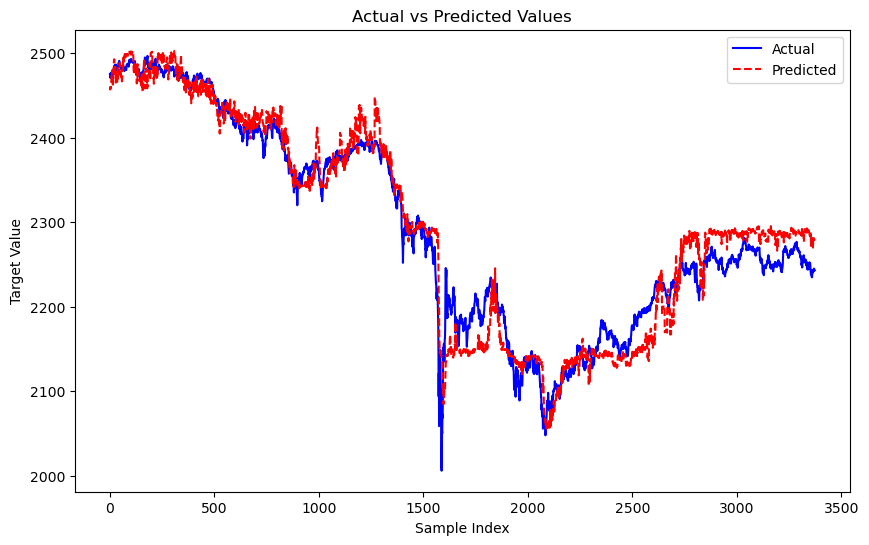

metrics for  lvl -  3 window -  25 no_of_neighbours -  5 ofi -  False


2024-12-07 00:28:41.871729: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 00:28:42.081331: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 554.7275341336531
R² Score: 0.9613048166189555


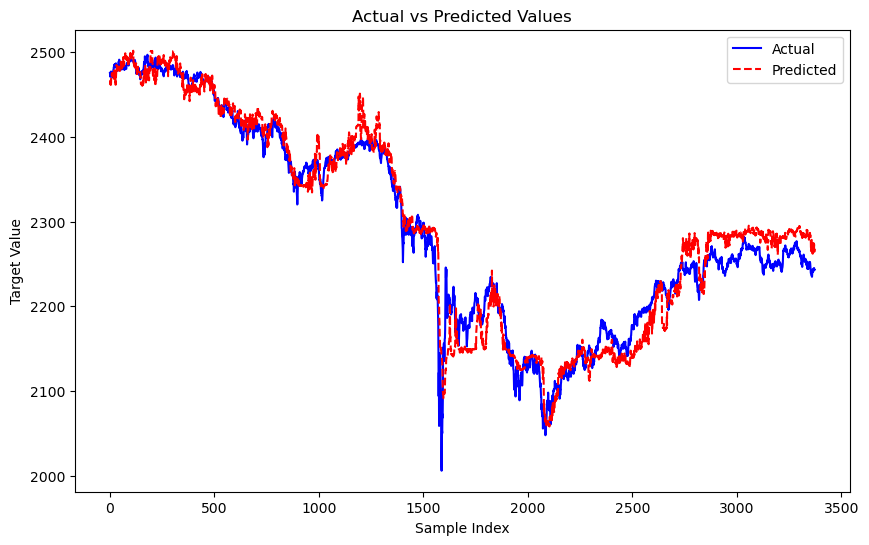

metrics for  lvl -  5 window -  25 no_of_neighbours -  5 ofi -  True


2024-12-07 00:28:43.681961: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 00:28:44.004473: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 817.4845036870221
R² Score: 0.9429761264136025


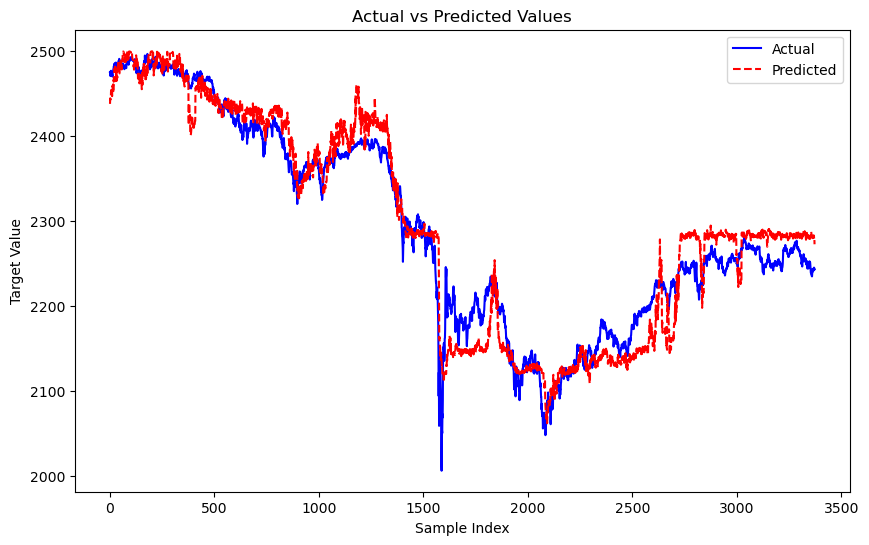

metrics for  lvl -  5 window -  25 no_of_neighbours -  5 ofi -  False


2024-12-07 00:28:45.883334: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 00:28:46.111270: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 662.637232037387
R² Score: 0.9537775436929787


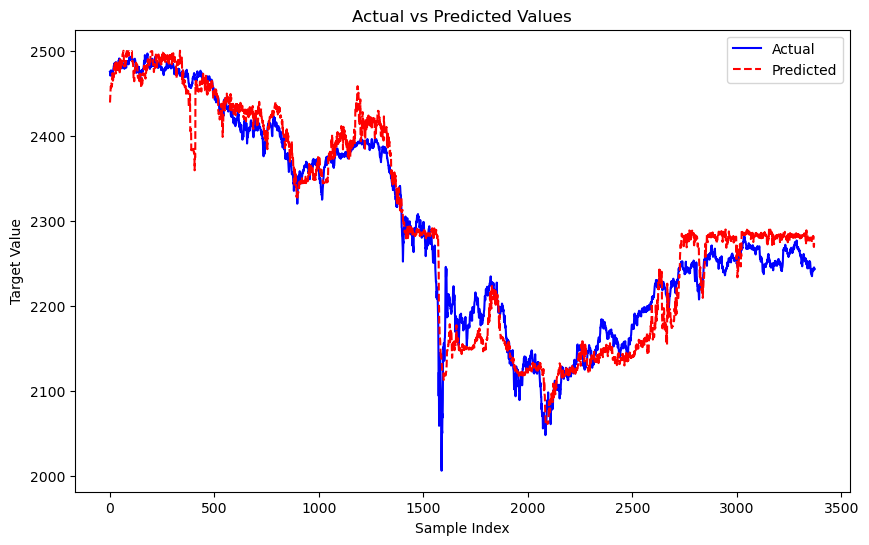

metrics for  lvl -  10 window -  25 no_of_neighbours -  5 ofi -  True


2024-12-07 00:28:48.082760: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 00:28:48.388512: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 902.6389658427215
R² Score: 0.9370361516943467


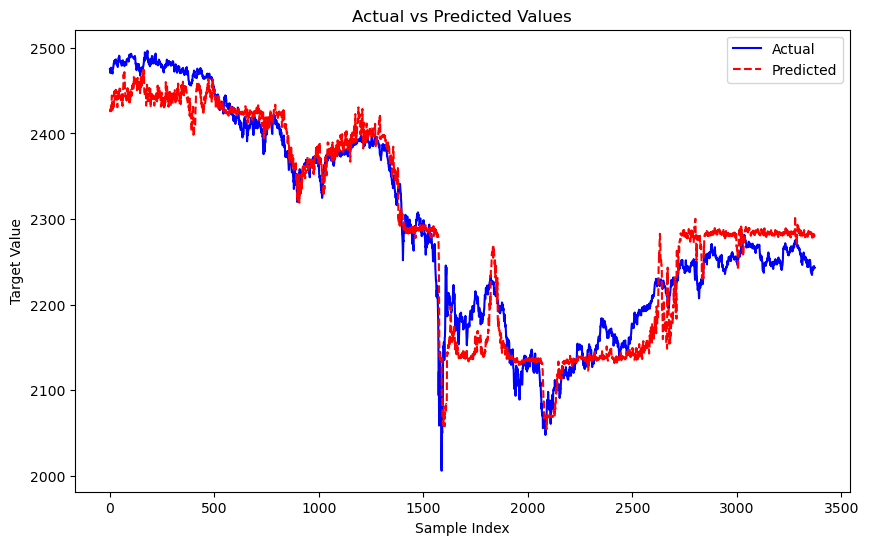

metrics for  lvl -  10 window -  25 no_of_neighbours -  5 ofi -  False


2024-12-07 00:28:51.230868: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 00:28:51.507131: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 650.0804010591919
R² Score: 0.9546534491555495


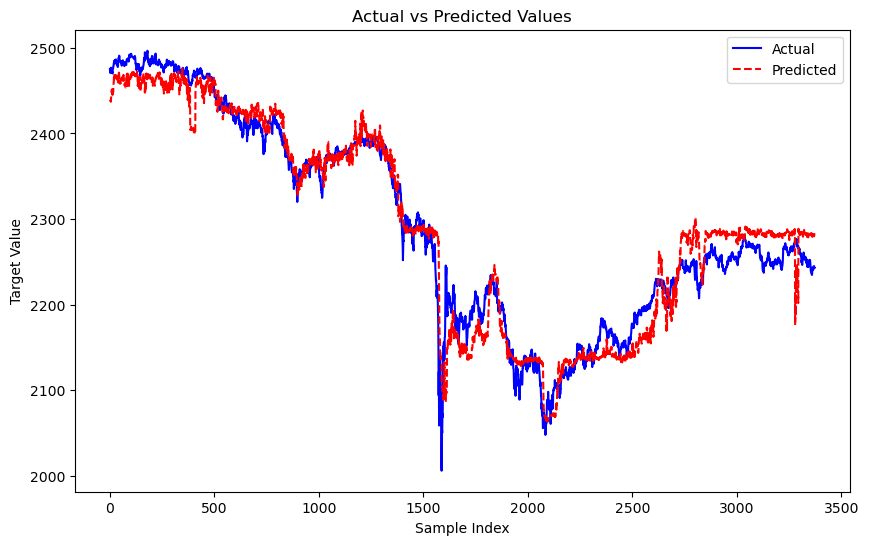

metrics for  lvl -  3 window -  50 no_of_neighbours -  5 ofi -  True


2024-12-07 00:28:53.859465: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 00:28:54.108056: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 931.8209863797297
R² Score: 0.9347240555900146


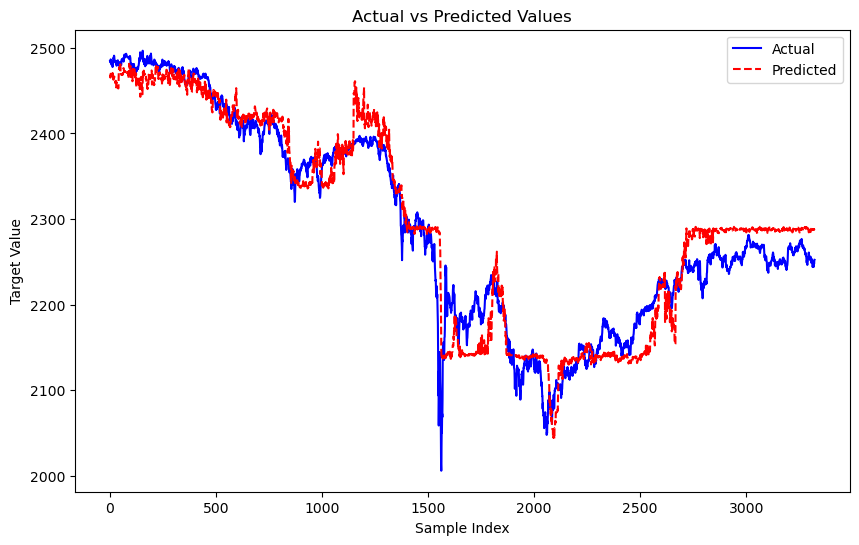

metrics for  lvl -  3 window -  50 no_of_neighbours -  5 ofi -  False


2024-12-07 00:28:56.117797: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 00:28:56.385420: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 759.479414236829
R² Score: 0.9467969312251048


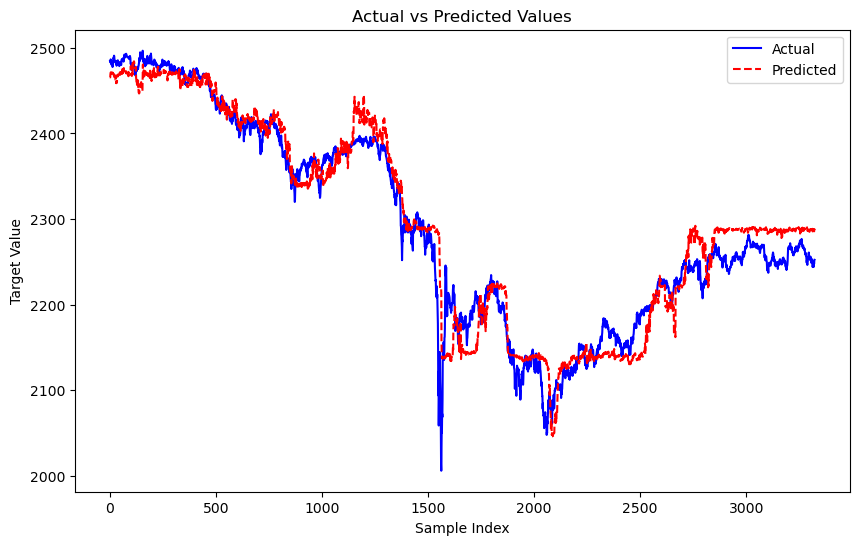

metrics for  lvl -  5 window -  50 no_of_neighbours -  5 ofi -  True


2024-12-07 00:28:58.325591: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 00:28:58.611871: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 1412.4756676465393
R² Score: 0.9010532231947613


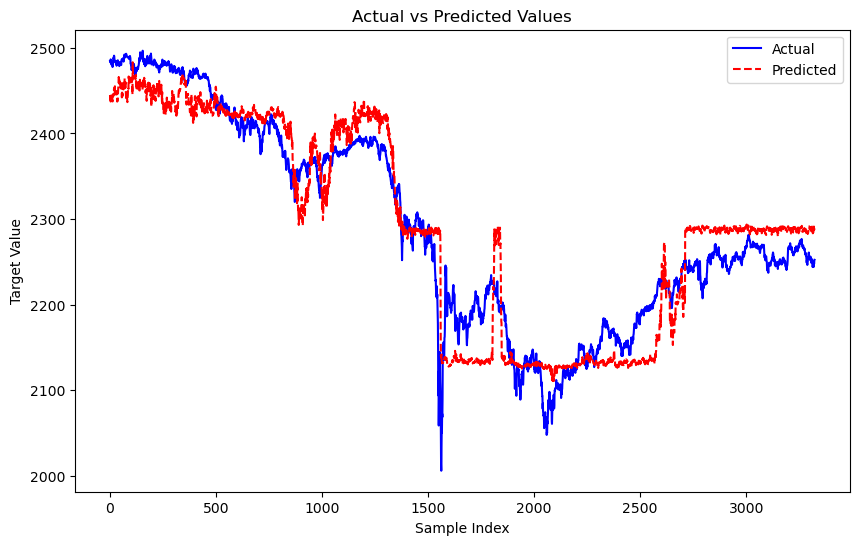

metrics for  lvl -  5 window -  50 no_of_neighbours -  5 ofi -  False


2024-12-07 00:29:01.133545: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 00:29:01.402580: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 1177.7343705550086
R² Score: 0.9174973257462682


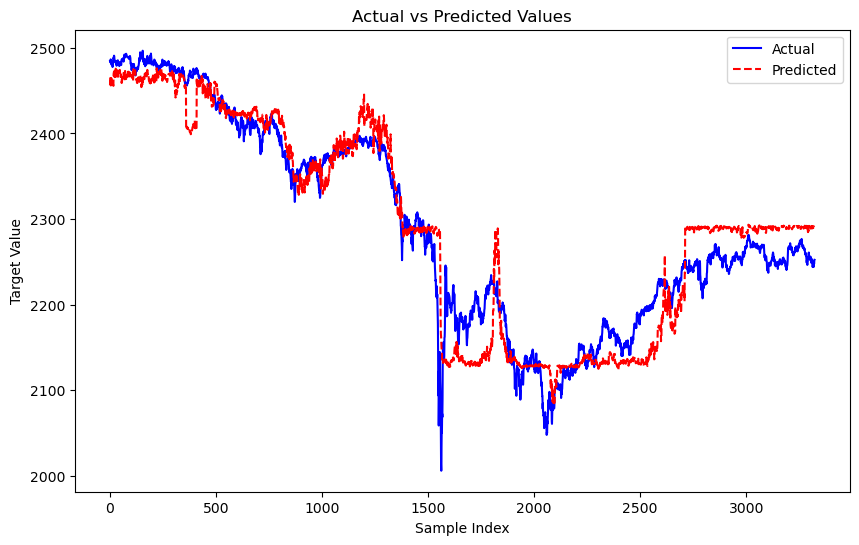

metrics for  lvl -  10 window -  50 no_of_neighbours -  5 ofi -  True


2024-12-07 00:29:03.831829: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 00:29:04.257828: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 1514.4715732654033
R² Score: 0.8939082037516063


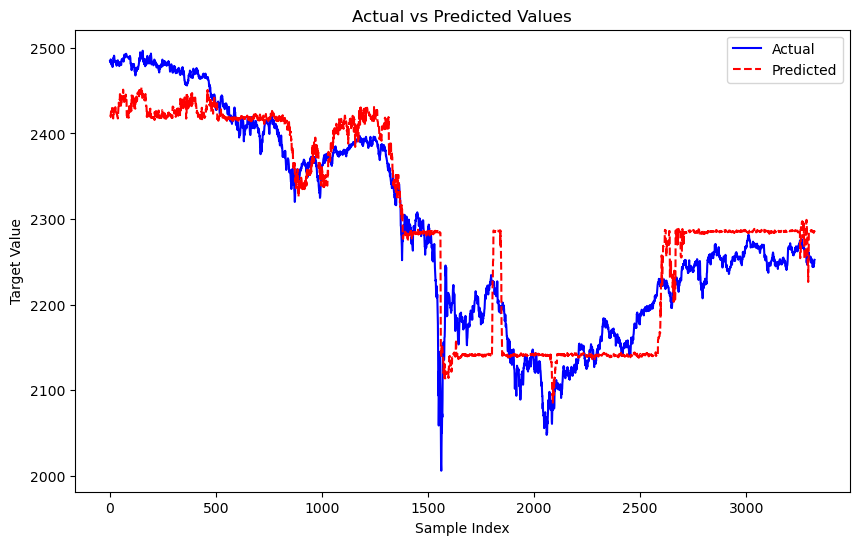

metrics for  lvl -  10 window -  50 no_of_neighbours -  5 ofi -  False


2024-12-07 00:29:09.659813: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 00:29:10.724665: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 1207.0041871373517
R² Score: 0.9154469159057016


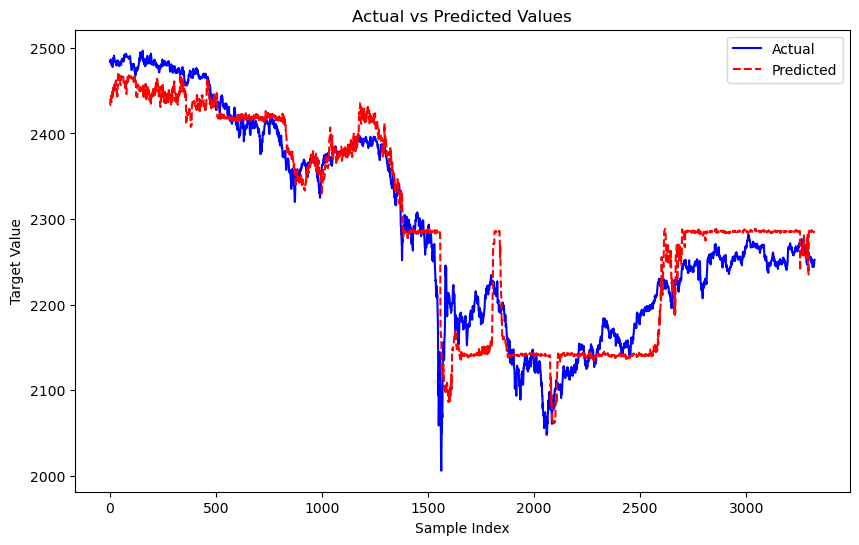

metrics for  lvl -  3 window -  100 no_of_neighbours -  5 ofi -  True


2024-12-07 00:29:14.643785: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 00:29:15.013952: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 1194.651995145245
R² Score: 0.9153847193958048


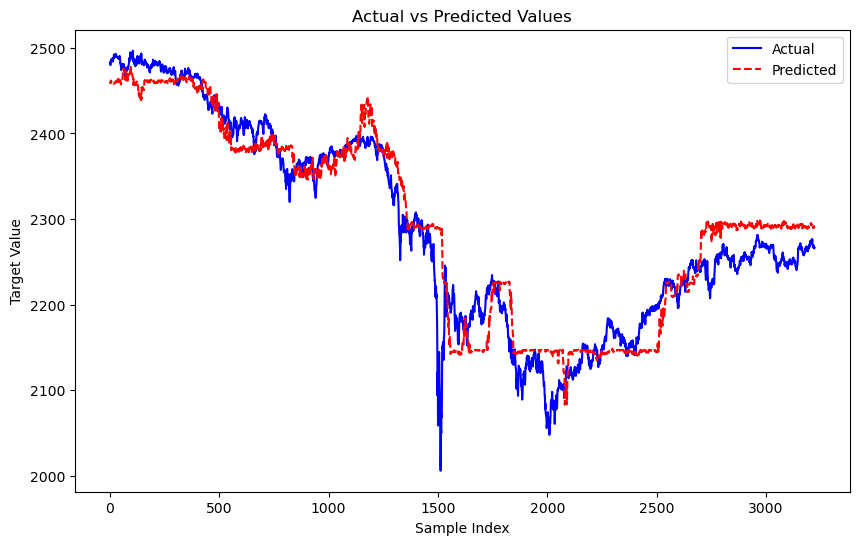

metrics for  lvl -  3 window -  100 no_of_neighbours -  5 ofi -  False


2024-12-07 00:29:18.039367: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 00:29:18.459106: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 1109.1801717306516
R² Score: 0.9214385512659795


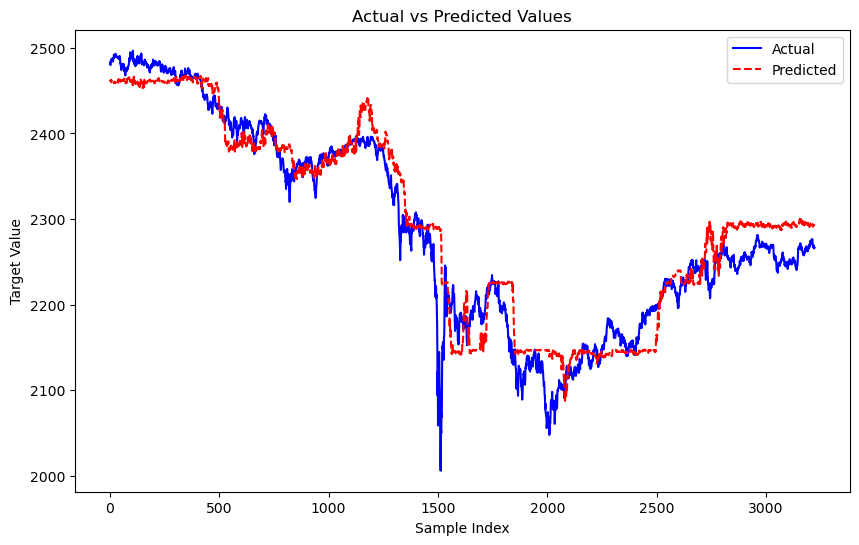

metrics for  lvl -  5 window -  100 no_of_neighbours -  5 ofi -  True


2024-12-07 00:29:20.967981: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 00:29:21.385337: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 1456.9608568475112
R² Score: 0.89680580434096


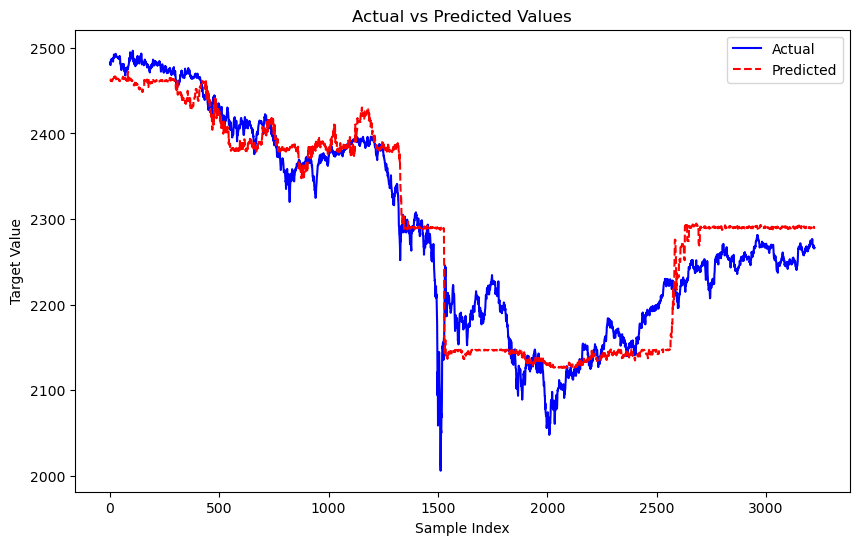

metrics for  lvl -  5 window -  100 no_of_neighbours -  5 ofi -  False


2024-12-07 00:29:25.854440: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 00:29:26.263634: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 1430.6238945510042
R² Score: 0.8986712090479686


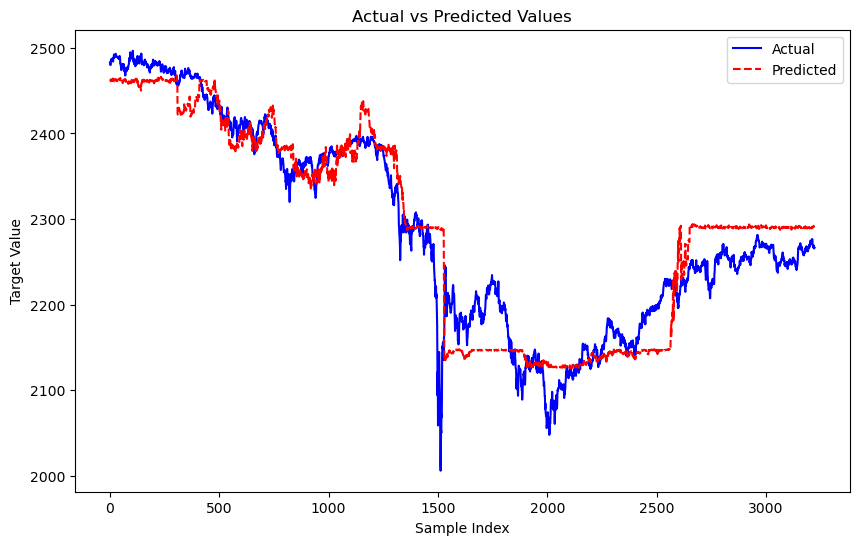

metrics for  lvl -  10 window -  100 no_of_neighbours -  5 ofi -  True


2024-12-07 00:29:30.612643: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 00:29:31.435215: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 1907.2162561395867
R² Score: 0.8649149381226175


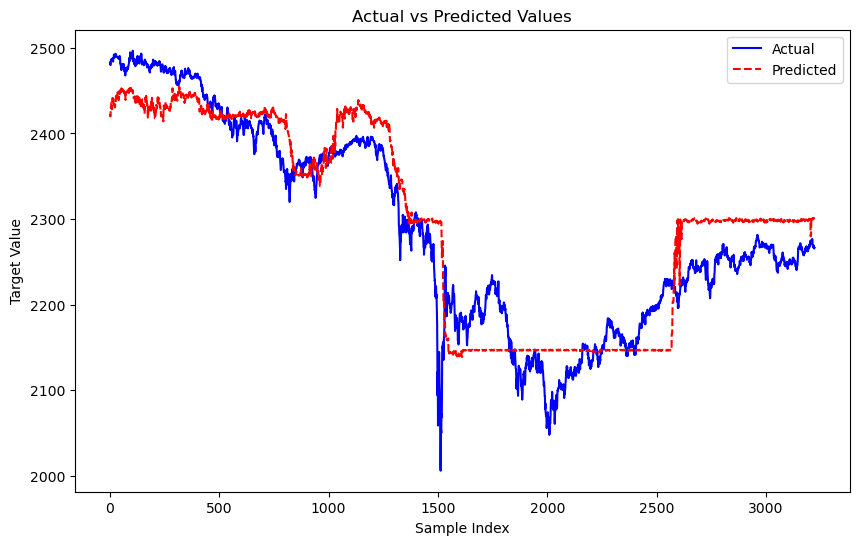

metrics for  lvl -  10 window -  100 no_of_neighbours -  5 ofi -  False


2024-12-07 00:29:39.587607: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 00:29:40.155313: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 1706.5925811875816
R² Score: 0.8791247905490096


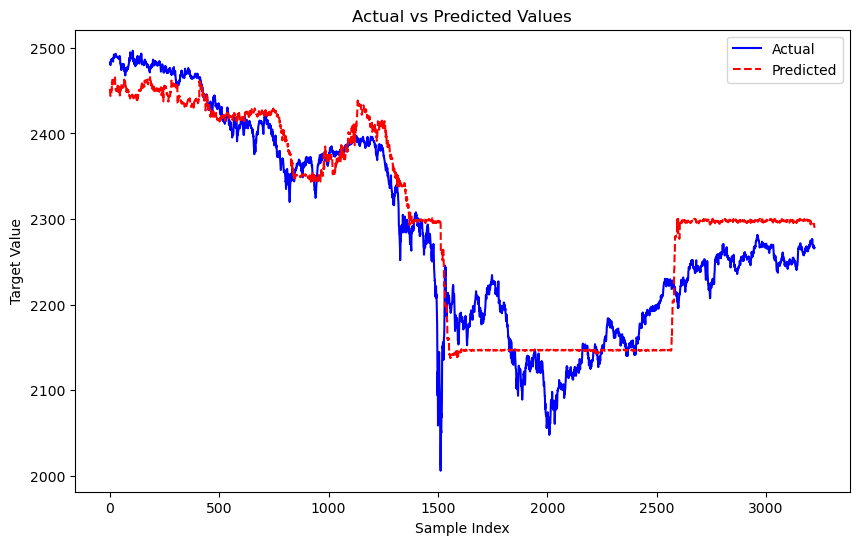

metrics for  lvl -  3 window -  25 no_of_neighbours -  10 ofi -  True


2024-12-07 00:29:46.870595: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 00:29:47.148448: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 701.026520952462
R² Score: 0.9510996874788346


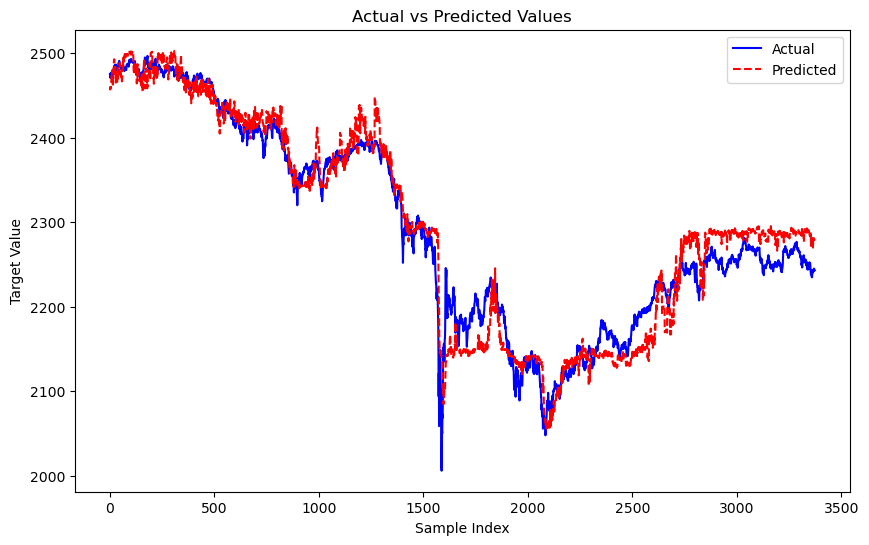

metrics for  lvl -  3 window -  25 no_of_neighbours -  10 ofi -  False


2024-12-07 00:29:49.071606: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 00:29:49.331511: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 554.7275341336531
R² Score: 0.9613048166189555


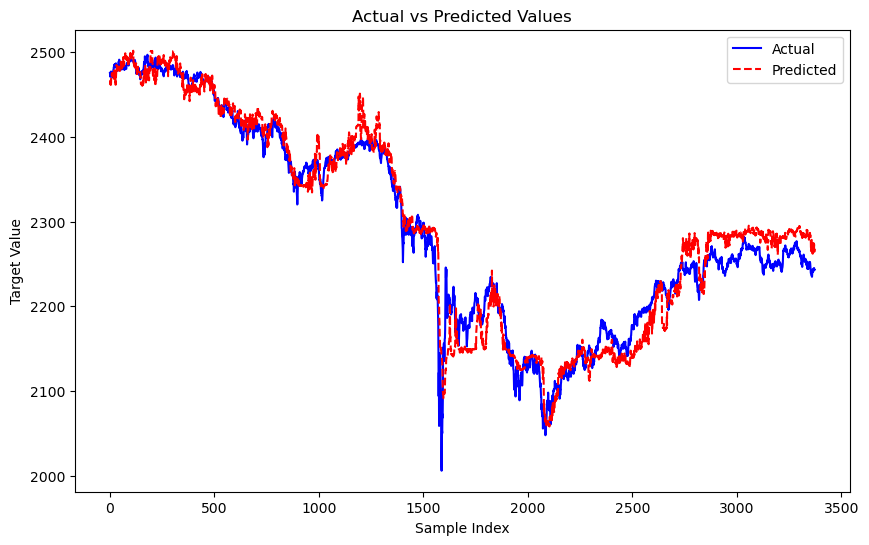

metrics for  lvl -  5 window -  25 no_of_neighbours -  10 ofi -  True


2024-12-07 00:29:50.933920: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 00:29:51.191067: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 817.4845036870221
R² Score: 0.9429761264136025


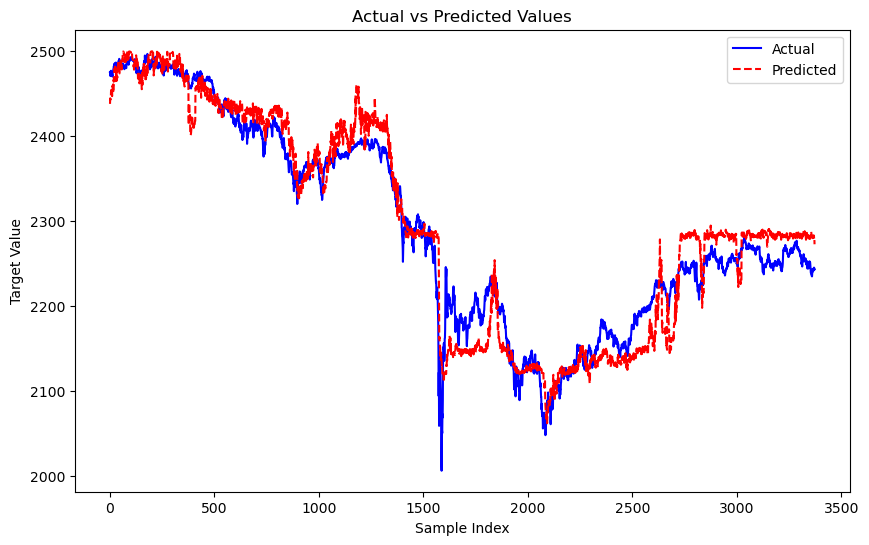

metrics for  lvl -  5 window -  25 no_of_neighbours -  10 ofi -  False


2024-12-07 00:29:53.077793: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 00:29:53.302438: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 662.637232037387
R² Score: 0.9537775436929787


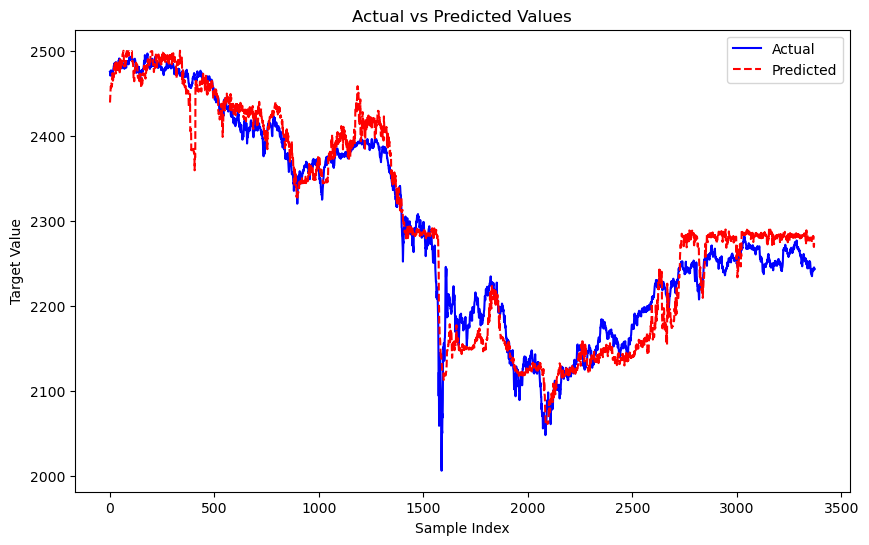

metrics for  lvl -  10 window -  25 no_of_neighbours -  10 ofi -  True


2024-12-07 00:29:55.003211: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 00:29:55.303818: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 902.6389658427215
R² Score: 0.9370361516943467


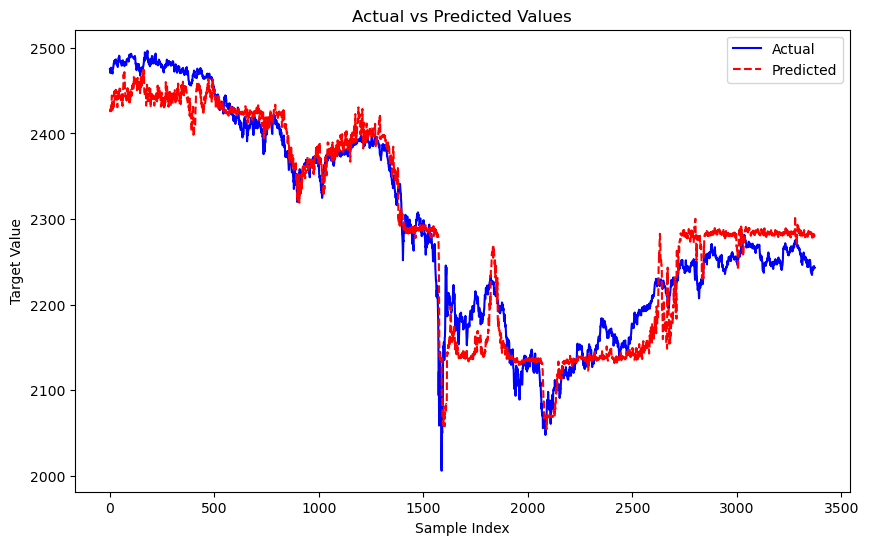

metrics for  lvl -  10 window -  25 no_of_neighbours -  10 ofi -  False


2024-12-07 00:29:57.794587: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 00:29:58.085154: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 650.0804010591919
R² Score: 0.9546534491555495


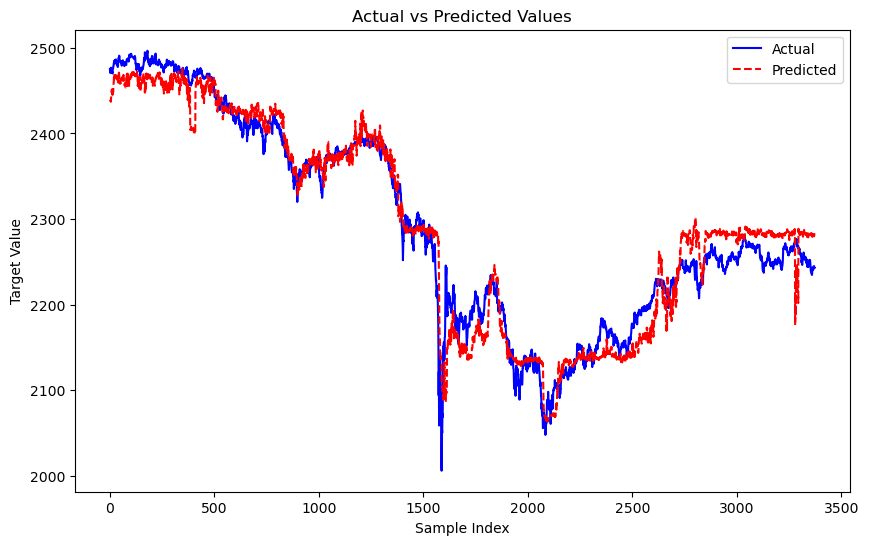

metrics for  lvl -  3 window -  50 no_of_neighbours -  10 ofi -  True


2024-12-07 00:30:00.352038: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 00:30:00.589161: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 931.8209863797297
R² Score: 0.9347240555900146


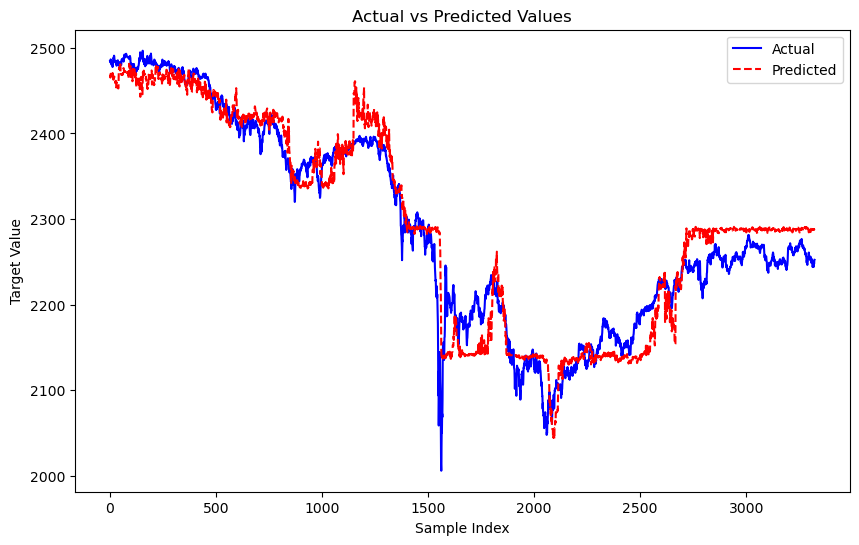

metrics for  lvl -  3 window -  50 no_of_neighbours -  10 ofi -  False


2024-12-07 00:30:02.437482: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 00:30:02.670119: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 759.479414236829
R² Score: 0.9467969312251048


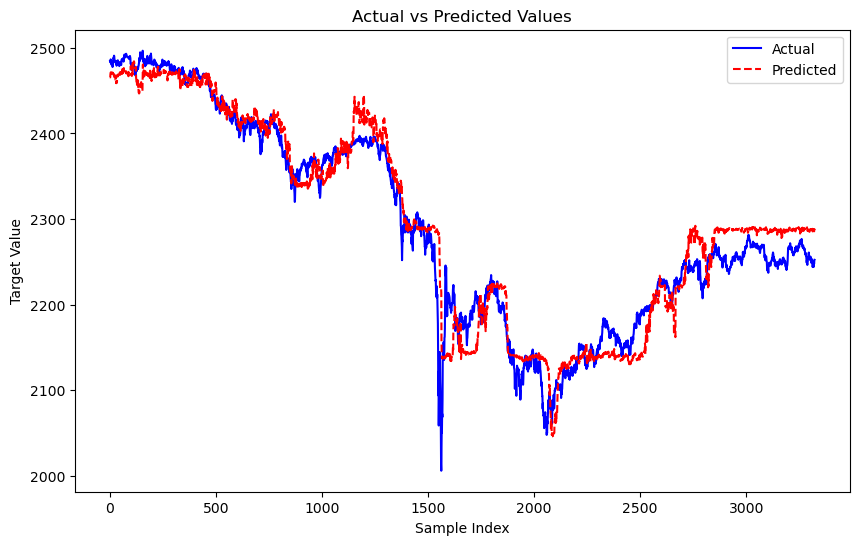

metrics for  lvl -  5 window -  50 no_of_neighbours -  10 ofi -  True


2024-12-07 00:30:04.506685: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 00:30:04.796038: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 1412.4756676465393
R² Score: 0.9010532231947613


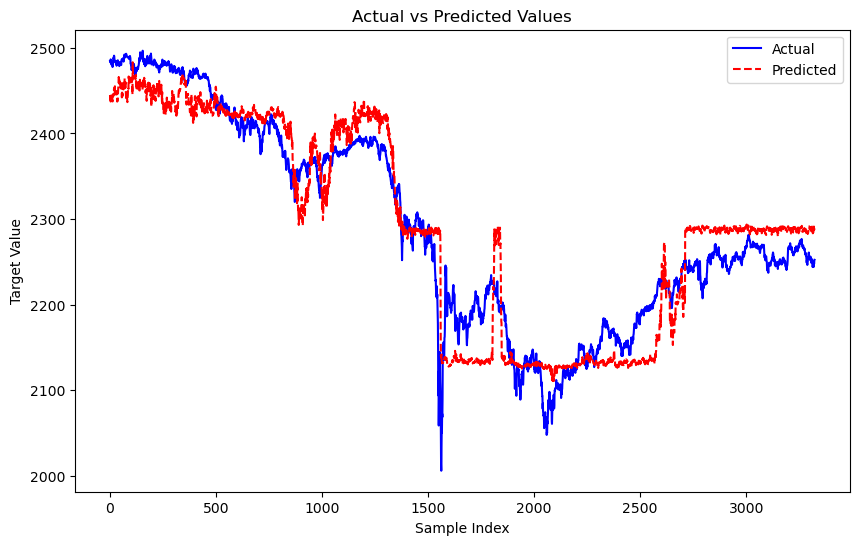

metrics for  lvl -  5 window -  50 no_of_neighbours -  10 ofi -  False


2024-12-07 00:30:07.233674: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 00:30:07.503618: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 1177.7343705550086
R² Score: 0.9174973257462682


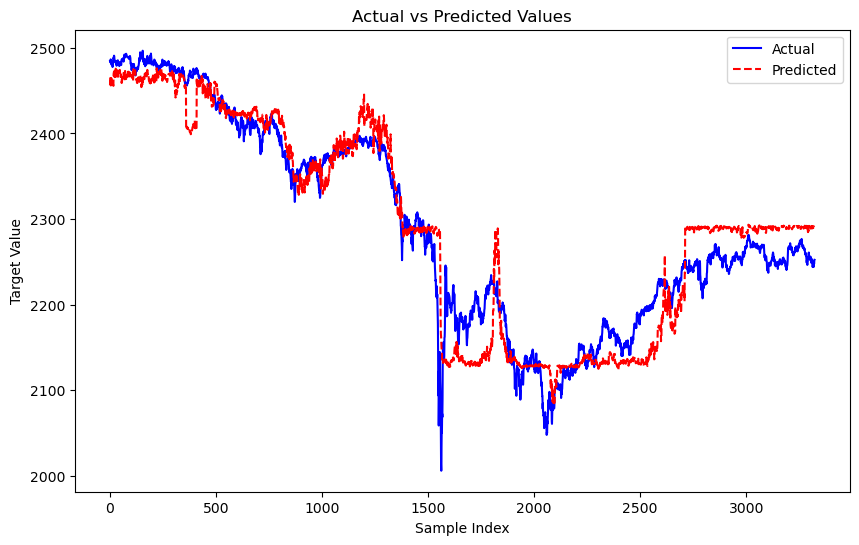

metrics for  lvl -  10 window -  50 no_of_neighbours -  10 ofi -  True


2024-12-07 00:30:09.760557: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 00:30:10.188218: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 1514.4715732654033
R² Score: 0.8939082037516063


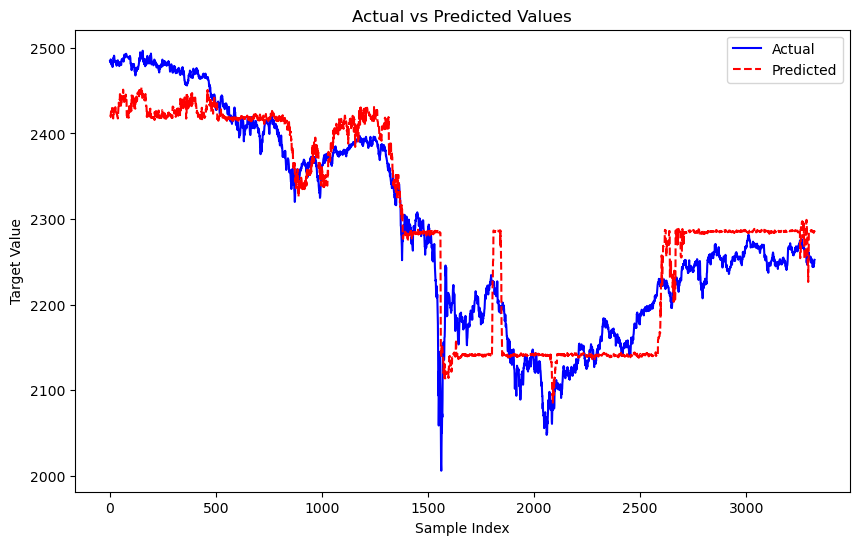

metrics for  lvl -  10 window -  50 no_of_neighbours -  10 ofi -  False


2024-12-07 00:30:14.259795: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 00:30:14.610415: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 1207.0041871373517
R² Score: 0.9154469159057016


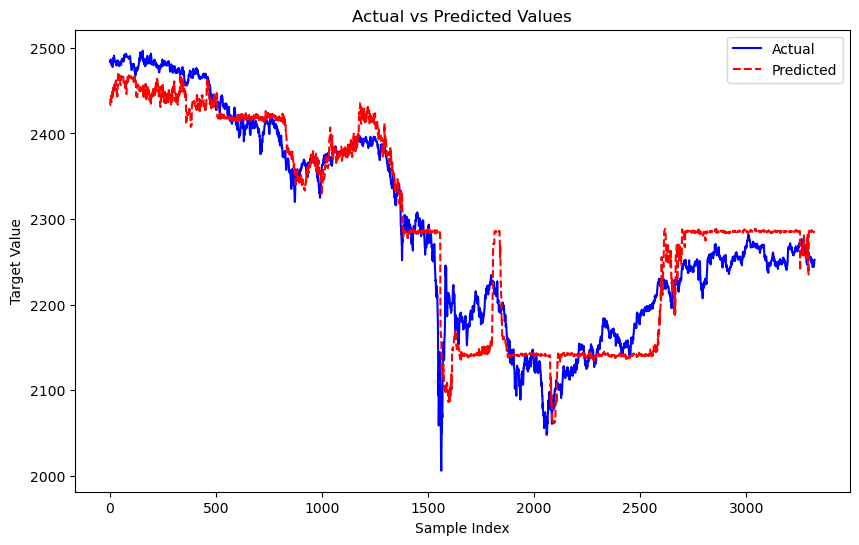

metrics for  lvl -  3 window -  100 no_of_neighbours -  10 ofi -  True


2024-12-07 00:30:17.890187: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 00:30:18.217054: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 1194.651995145245
R² Score: 0.9153847193958048


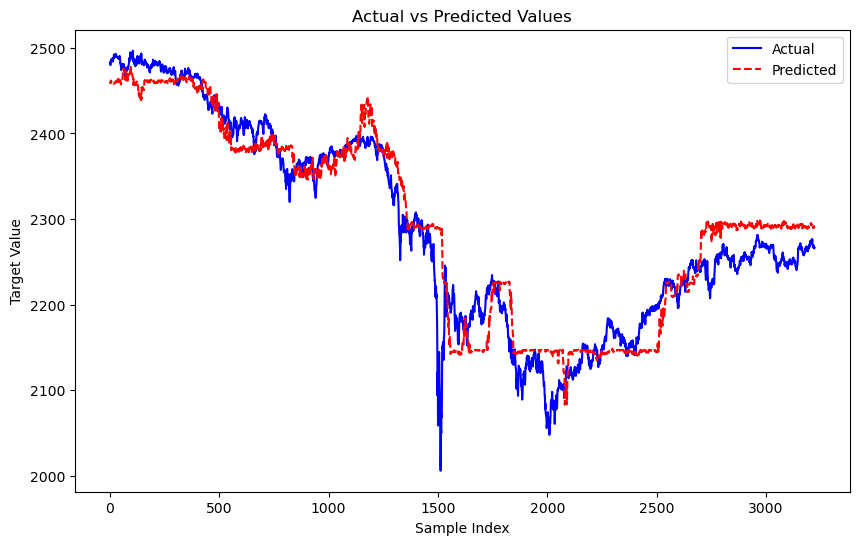

metrics for  lvl -  3 window -  100 no_of_neighbours -  10 ofi -  False


2024-12-07 00:30:21.070481: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 00:30:21.342055: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 1109.1801717306516
R² Score: 0.9214385512659795


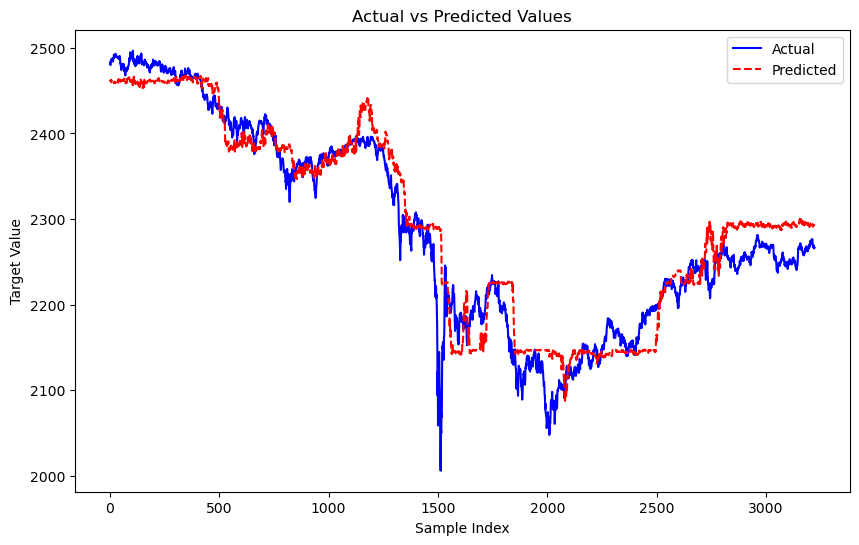

metrics for  lvl -  5 window -  100 no_of_neighbours -  10 ofi -  True


2024-12-07 00:30:23.710718: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 00:30:24.132161: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 1456.9608568475112
R² Score: 0.89680580434096


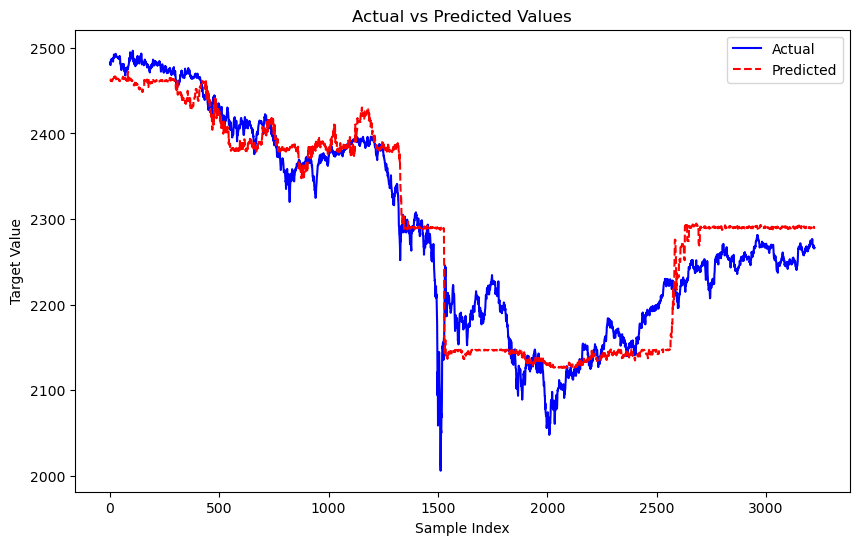

metrics for  lvl -  5 window -  100 no_of_neighbours -  10 ofi -  False


2024-12-07 00:30:27.900835: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 00:30:28.263225: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 1430.6238945510042
R² Score: 0.8986712090479686


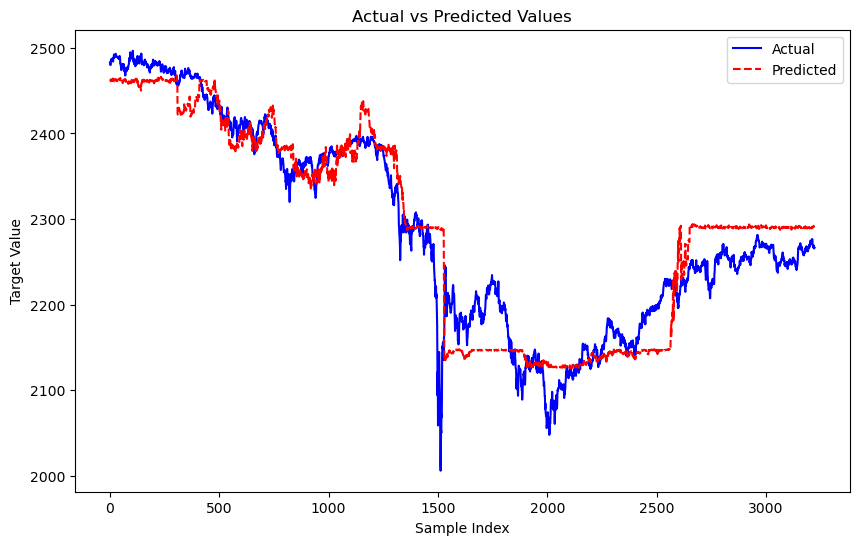

metrics for  lvl -  10 window -  100 no_of_neighbours -  10 ofi -  True


2024-12-07 00:30:32.008048: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 00:30:32.707365: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 1907.2162561395867
R² Score: 0.8649149381226175


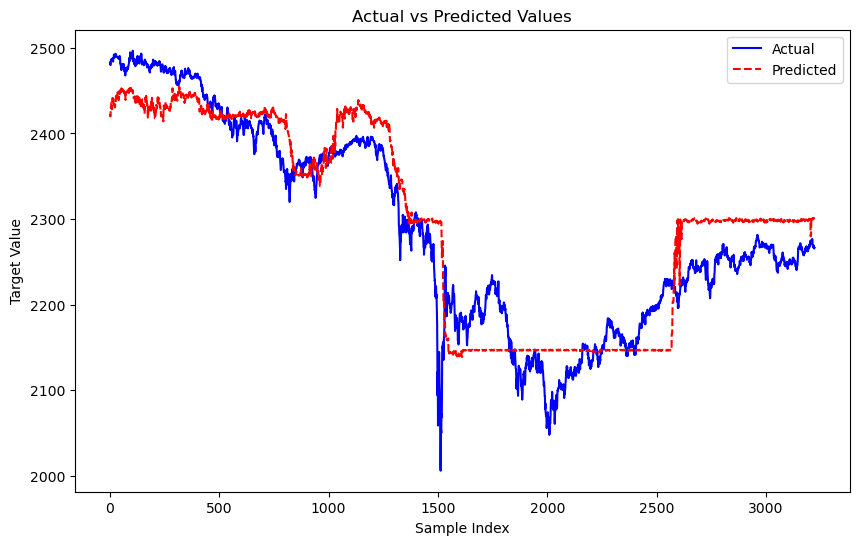

metrics for  lvl -  10 window -  100 no_of_neighbours -  10 ofi -  False


2024-12-07 00:30:39.832832: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 00:30:40.386960: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 1706.5925811875816
R² Score: 0.8791247905490096


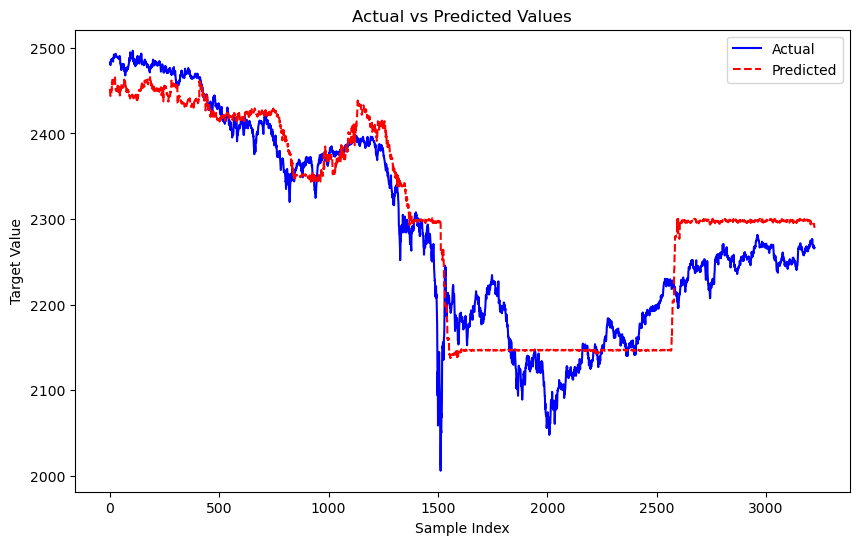

metrics for  lvl -  3 window -  25 no_of_neighbours -  15 ofi -  True


2024-12-07 00:30:45.957877: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 00:30:46.165877: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 701.026520952462
R² Score: 0.9510996874788346


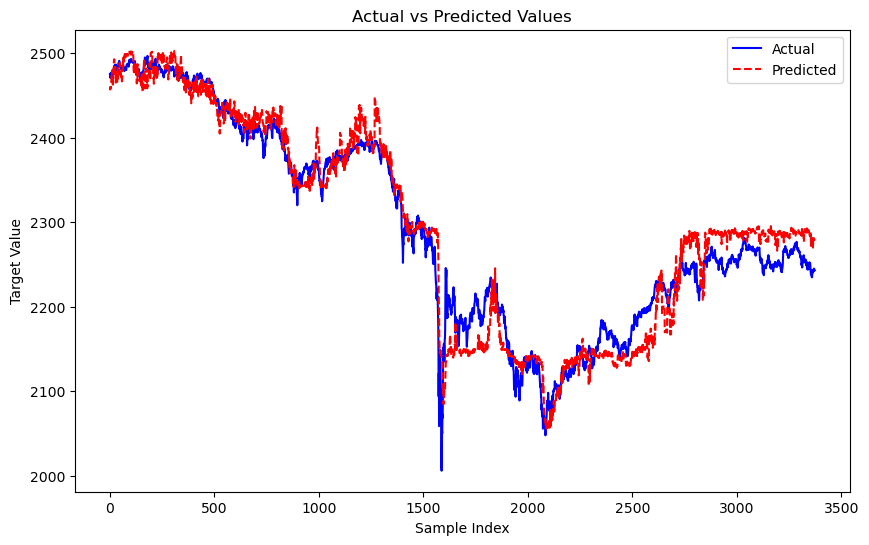

metrics for  lvl -  3 window -  25 no_of_neighbours -  15 ofi -  False


2024-12-07 00:30:47.610612: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 00:30:47.811011: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 554.7275341336531
R² Score: 0.9613048166189555


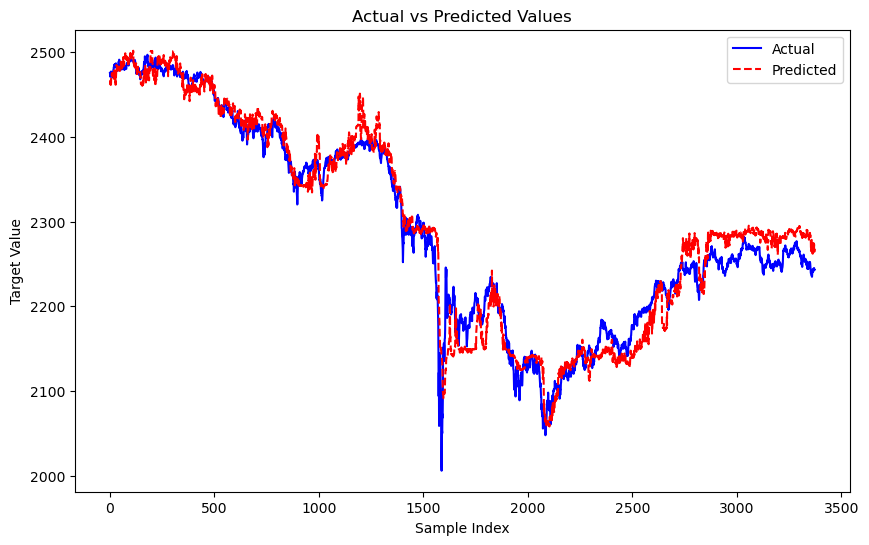

metrics for  lvl -  5 window -  25 no_of_neighbours -  15 ofi -  True


2024-12-07 00:30:49.217058: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 00:30:49.446511: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 817.4845036870221
R² Score: 0.9429761264136025


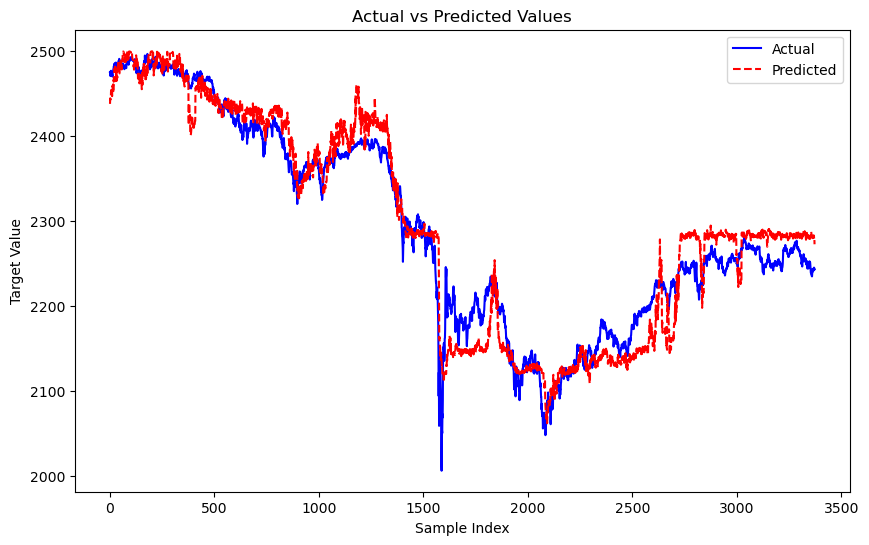

metrics for  lvl -  5 window -  25 no_of_neighbours -  15 ofi -  False


2024-12-07 00:30:51.408986: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 00:30:51.641031: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 662.637232037387
R² Score: 0.9537775436929787


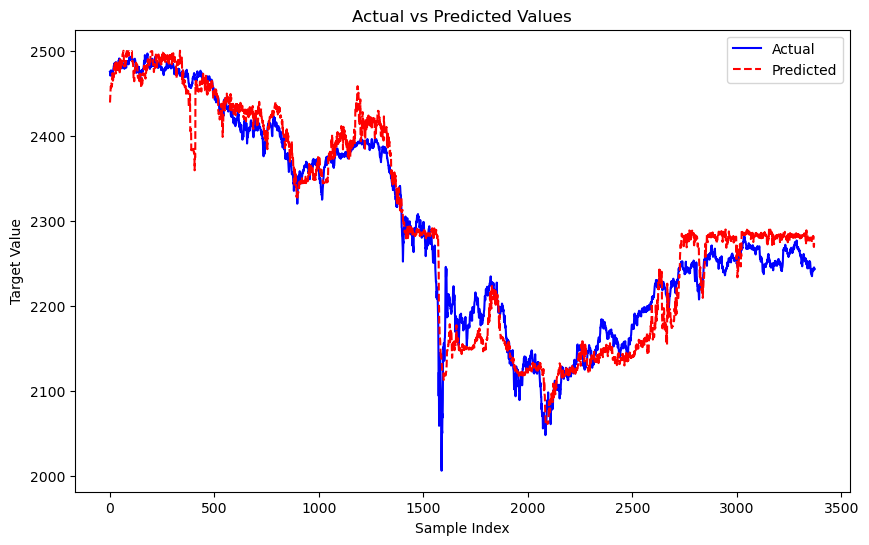

metrics for  lvl -  10 window -  25 no_of_neighbours -  15 ofi -  True


2024-12-07 00:30:53.340975: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 00:30:53.641956: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 902.6389658427215
R² Score: 0.9370361516943467


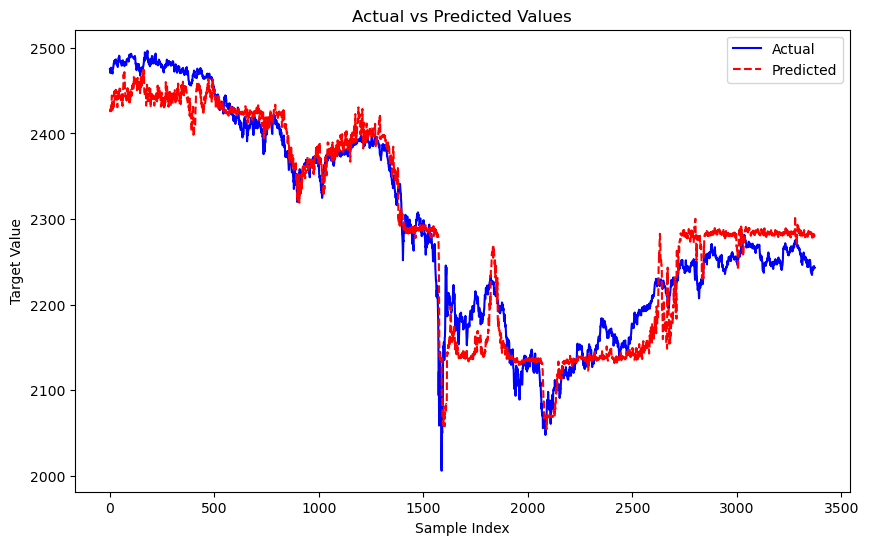

metrics for  lvl -  10 window -  25 no_of_neighbours -  15 ofi -  False


2024-12-07 00:30:56.220483: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 00:30:56.487610: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 650.0804010591919
R² Score: 0.9546534491555495


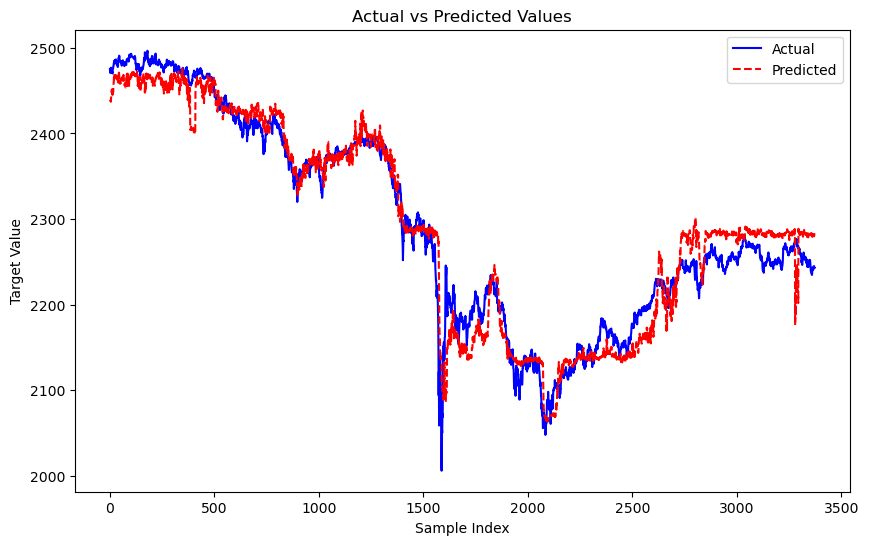

metrics for  lvl -  3 window -  50 no_of_neighbours -  15 ofi -  True


2024-12-07 00:30:58.642908: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 00:30:58.890332: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 931.8209863797297
R² Score: 0.9347240555900146


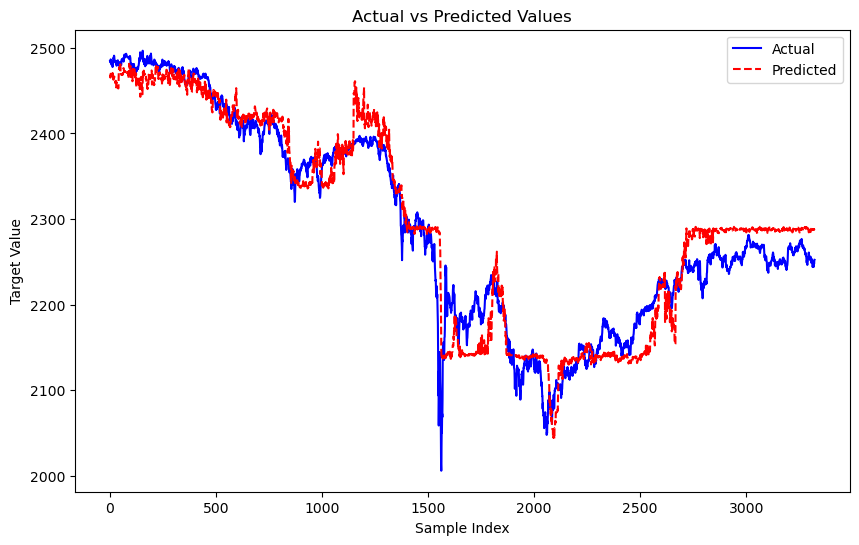

metrics for  lvl -  3 window -  50 no_of_neighbours -  15 ofi -  False


2024-12-07 00:31:00.727186: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 00:31:00.940476: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 759.479414236829
R² Score: 0.9467969312251048


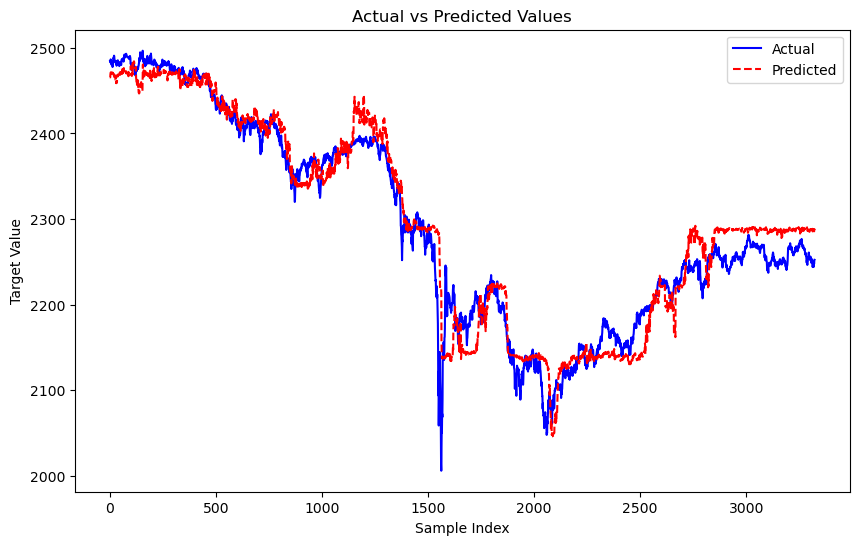

metrics for  lvl -  5 window -  50 no_of_neighbours -  15 ofi -  True


2024-12-07 00:31:02.823460: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 00:31:03.123529: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 1412.4756676465393
R² Score: 0.9010532231947613


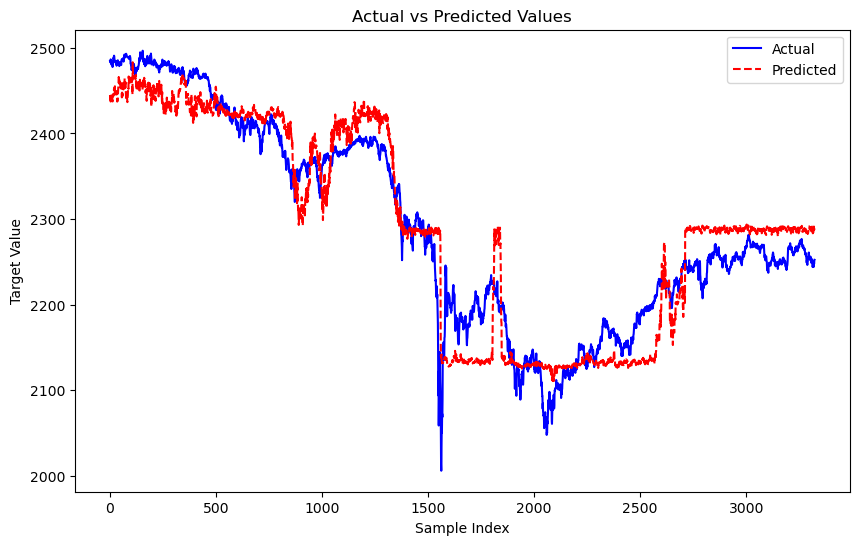

metrics for  lvl -  5 window -  50 no_of_neighbours -  15 ofi -  False


2024-12-07 00:31:05.563661: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 00:31:05.834952: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 1177.7343705550086
R² Score: 0.9174973257462682


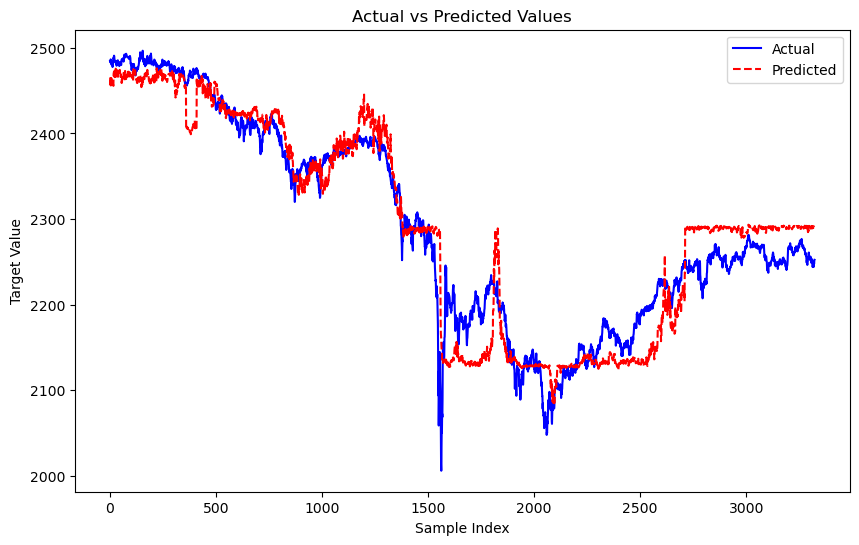

metrics for  lvl -  10 window -  50 no_of_neighbours -  15 ofi -  True


2024-12-07 00:31:08.087628: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 00:31:08.516328: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 1514.4715732654033
R² Score: 0.8939082037516063


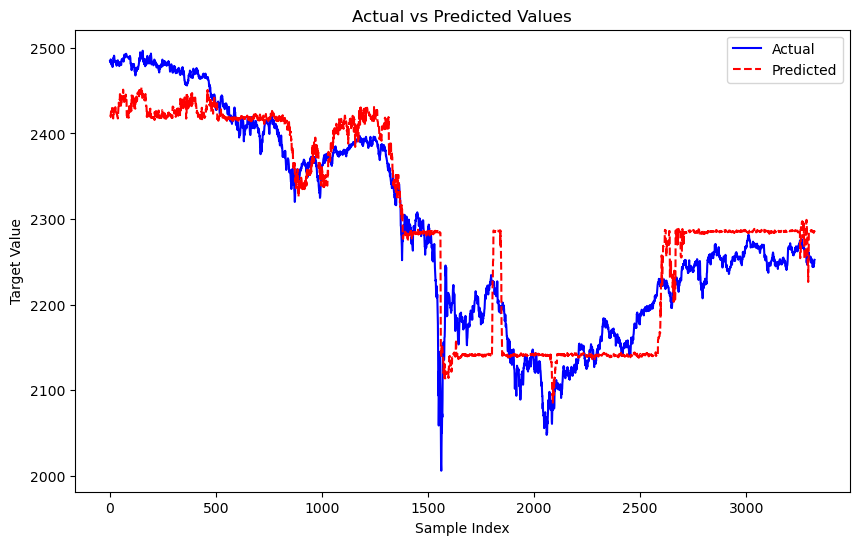

metrics for  lvl -  10 window -  50 no_of_neighbours -  15 ofi -  False


2024-12-07 00:31:12.551646: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 00:31:12.977243: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 1207.0041871373517
R² Score: 0.9154469159057016


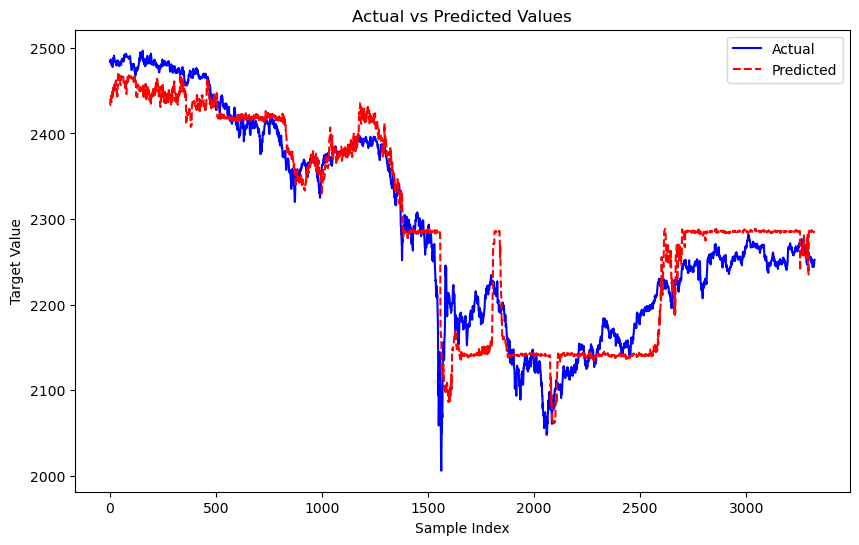

metrics for  lvl -  3 window -  100 no_of_neighbours -  15 ofi -  True


2024-12-07 00:31:16.271051: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 00:31:16.582048: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 1194.651995145245
R² Score: 0.9153847193958048


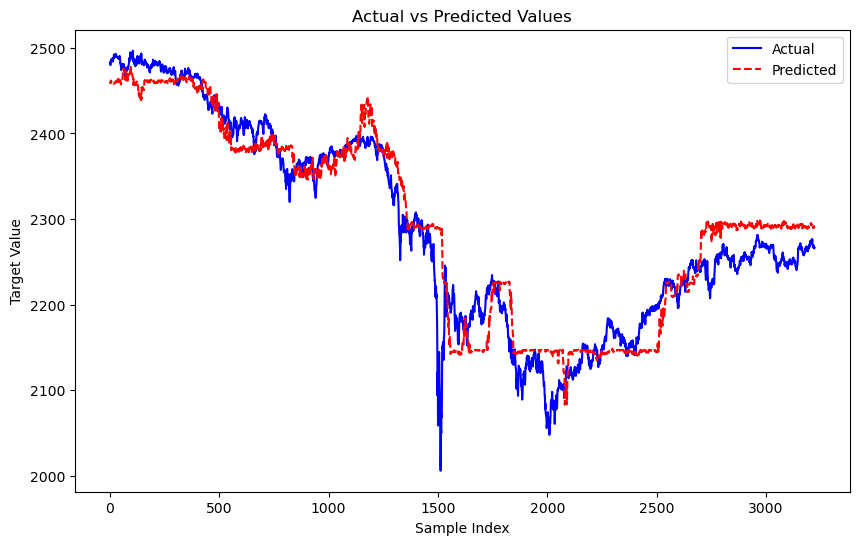

metrics for  lvl -  3 window -  100 no_of_neighbours -  15 ofi -  False


2024-12-07 00:31:19.267946: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 00:31:19.544239: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 1109.1801717306516
R² Score: 0.9214385512659795


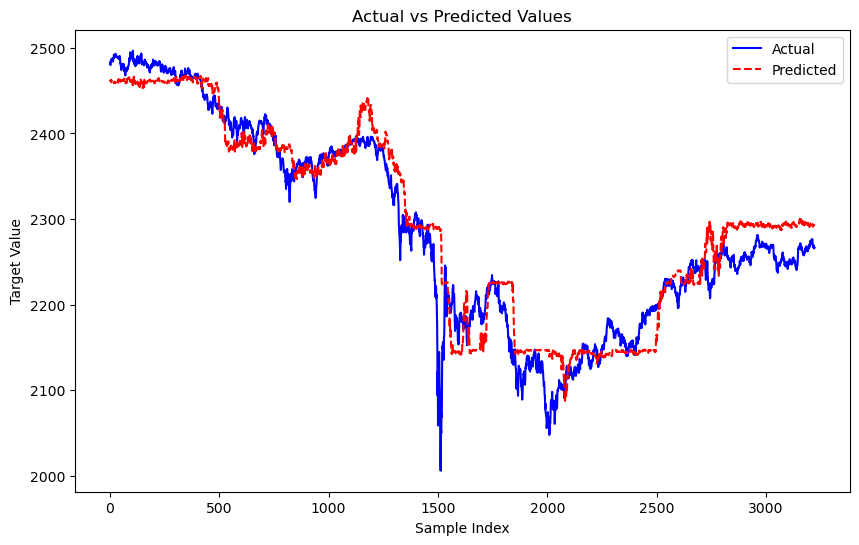

metrics for  lvl -  5 window -  100 no_of_neighbours -  15 ofi -  True


2024-12-07 00:31:22.021799: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 00:31:22.426448: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 1456.9608568475112
R² Score: 0.89680580434096


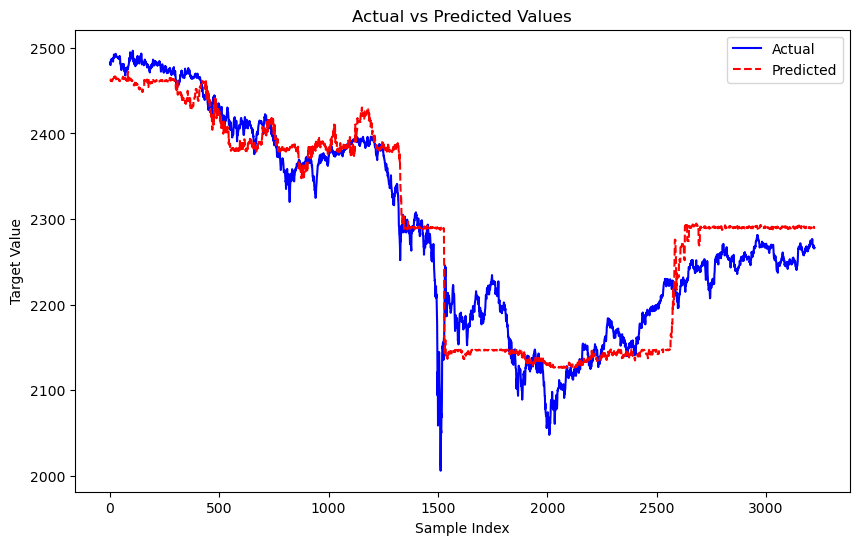

metrics for  lvl -  5 window -  100 no_of_neighbours -  15 ofi -  False


2024-12-07 00:31:26.209956: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 00:31:26.557959: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 1430.6238945510042
R² Score: 0.8986712090479686


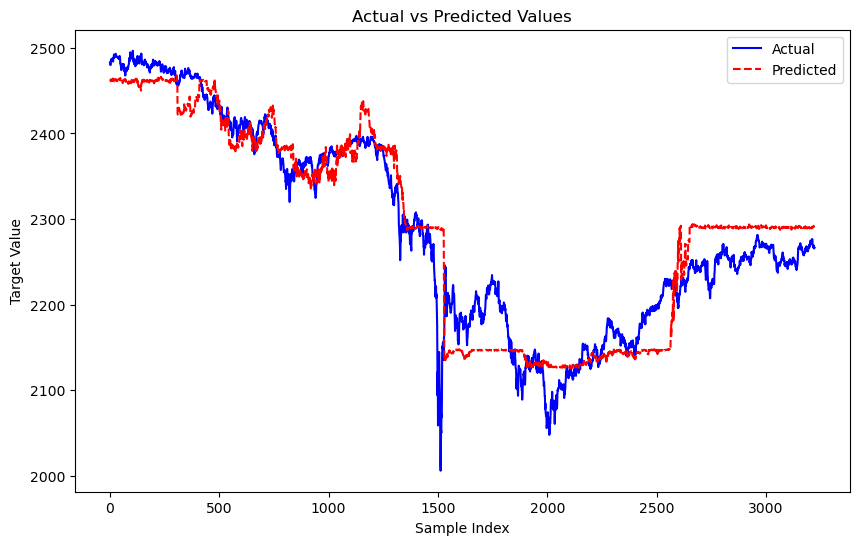

metrics for  lvl -  10 window -  100 no_of_neighbours -  15 ofi -  True


2024-12-07 00:31:30.098441: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 00:31:30.783562: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 1907.2162561395867
R² Score: 0.8649149381226175


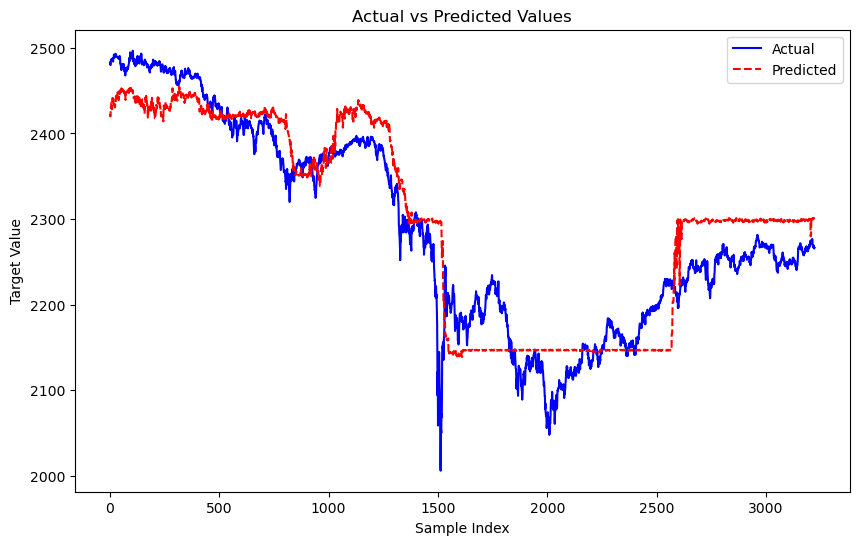

metrics for  lvl -  10 window -  100 no_of_neighbours -  15 ofi -  False


2024-12-07 00:31:37.420275: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 00:31:37.974970: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 1706.5925811875816
R² Score: 0.8791247905490096


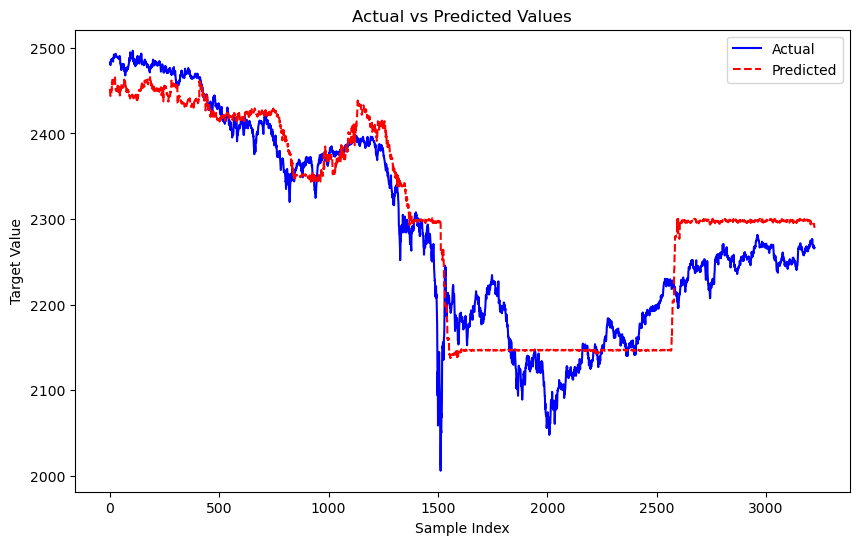

metrics for  lvl -  3 window -  25 no_of_neighbours -  20 ofi -  True


2024-12-07 00:31:43.717317: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 00:31:43.926231: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 701.026520952462
R² Score: 0.9510996874788346


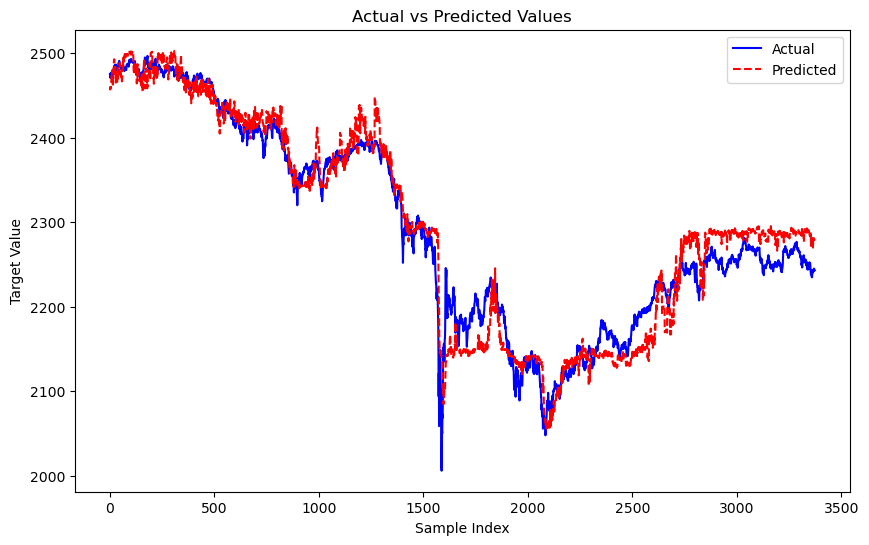

metrics for  lvl -  3 window -  25 no_of_neighbours -  20 ofi -  False


2024-12-07 00:31:45.367169: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 00:31:45.568120: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 554.7275341336531
R² Score: 0.9613048166189555


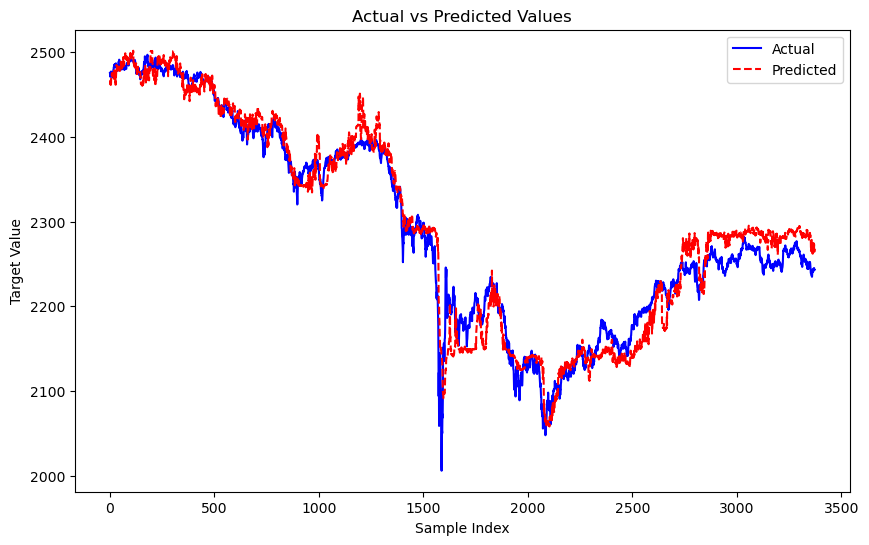

metrics for  lvl -  5 window -  25 no_of_neighbours -  20 ofi -  True


2024-12-07 00:31:47.121127: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 00:31:47.355401: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 817.4845036870221
R² Score: 0.9429761264136025


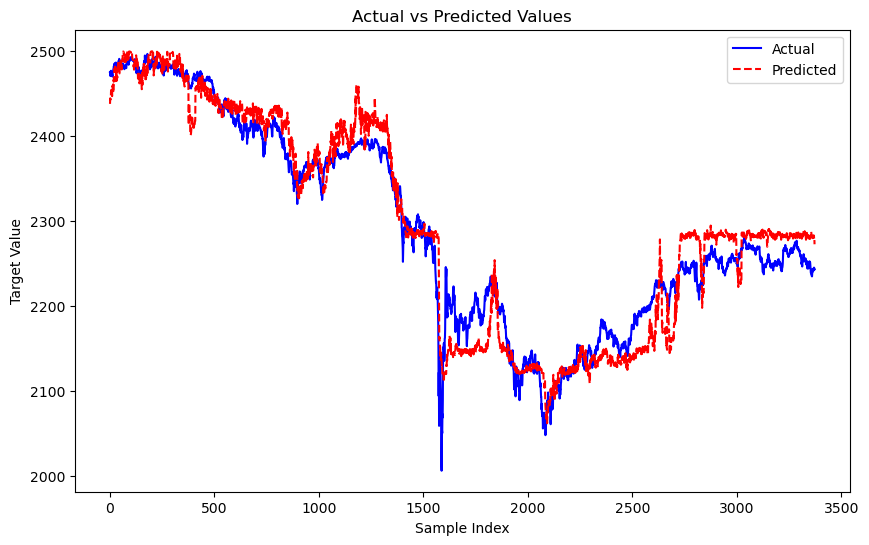

metrics for  lvl -  5 window -  25 no_of_neighbours -  20 ofi -  False


2024-12-07 00:31:49.162261: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 00:31:49.388301: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 662.637232037387
R² Score: 0.9537775436929787


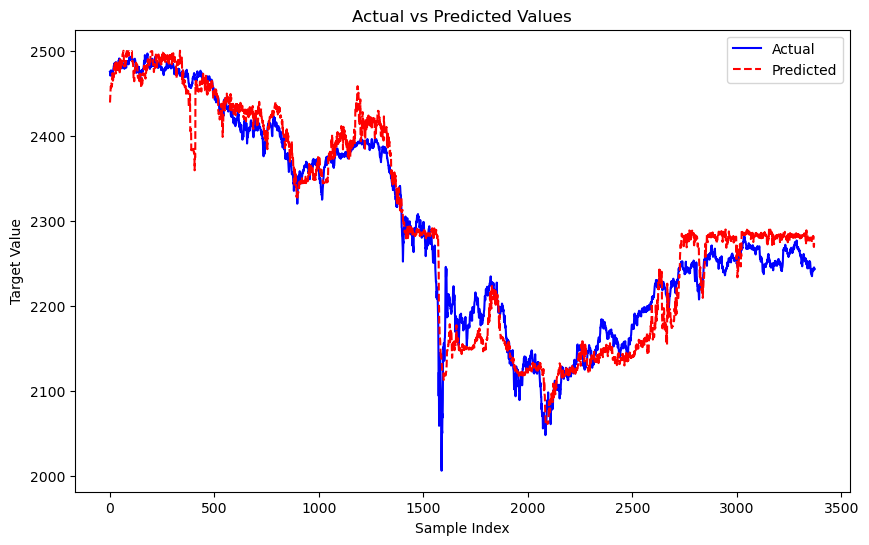

metrics for  lvl -  10 window -  25 no_of_neighbours -  20 ofi -  True


2024-12-07 00:31:51.103445: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 00:31:51.397293: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 902.6389658427215
R² Score: 0.9370361516943467


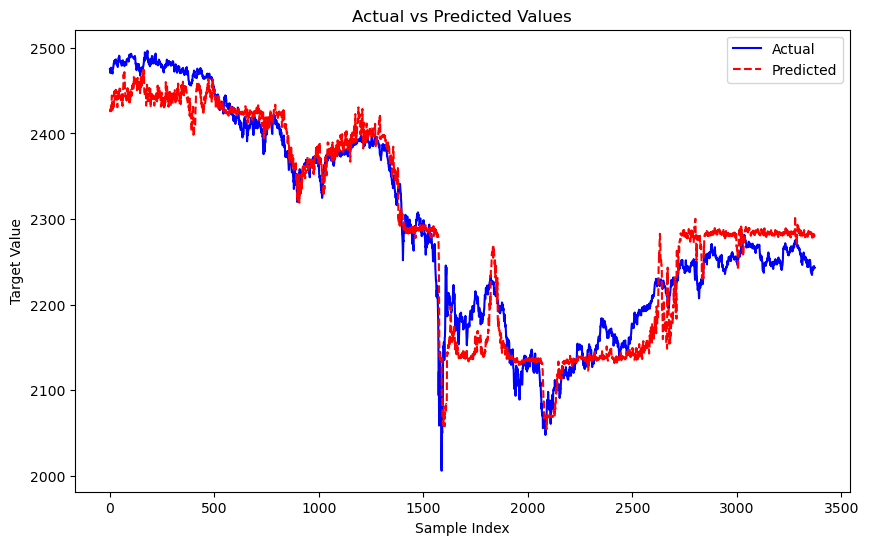

metrics for  lvl -  10 window -  25 no_of_neighbours -  20 ofi -  False


2024-12-07 00:31:53.886616: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 00:31:54.150252: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 650.0804010591919
R² Score: 0.9546534491555495


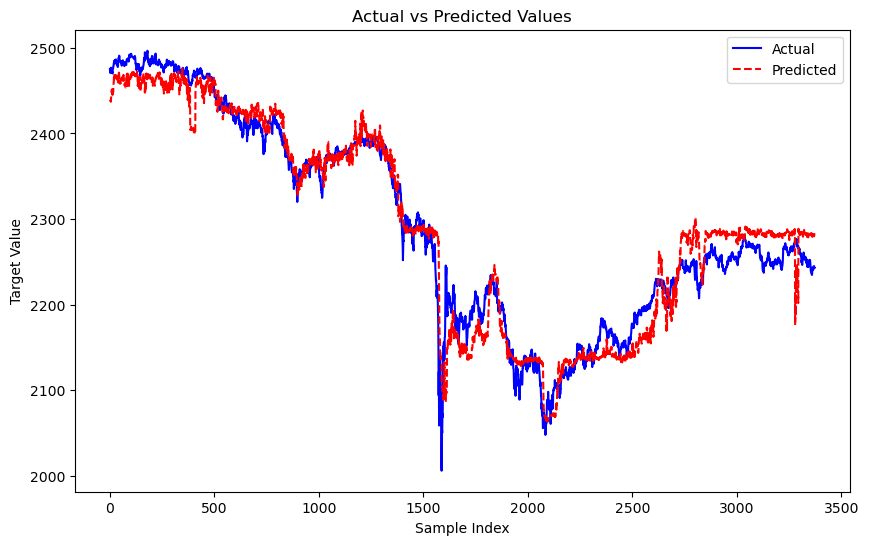

metrics for  lvl -  3 window -  50 no_of_neighbours -  20 ofi -  True


2024-12-07 00:31:56.264367: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 00:31:56.524580: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 931.8209863797297
R² Score: 0.9347240555900146


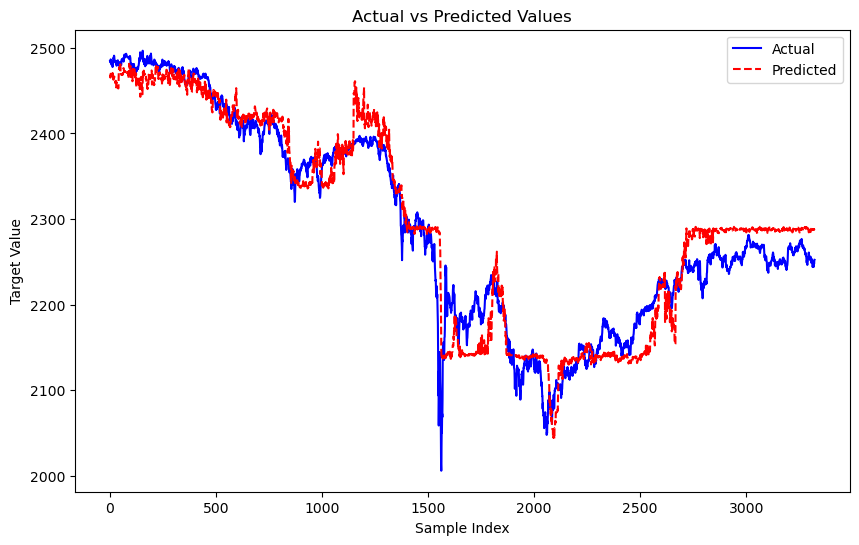

metrics for  lvl -  3 window -  50 no_of_neighbours -  20 ofi -  False


2024-12-07 00:31:58.429301: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 00:31:58.654910: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 759.479414236829
R² Score: 0.9467969312251048


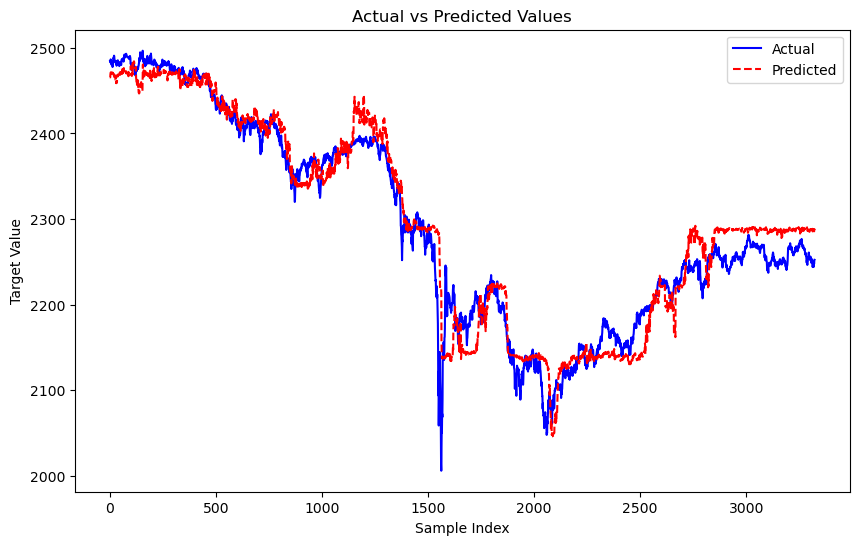

metrics for  lvl -  5 window -  50 no_of_neighbours -  20 ofi -  True


2024-12-07 00:32:00.365920: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 00:32:00.658106: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 1412.4756676465393
R² Score: 0.9010532231947613


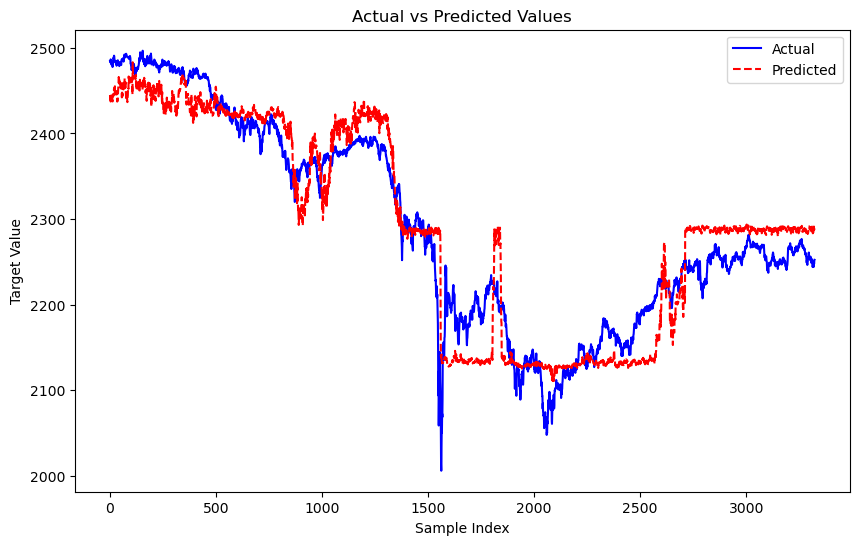

metrics for  lvl -  5 window -  50 no_of_neighbours -  20 ofi -  False


2024-12-07 00:32:03.106529: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 00:32:03.397776: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 1177.7343705550086
R² Score: 0.9174973257462682


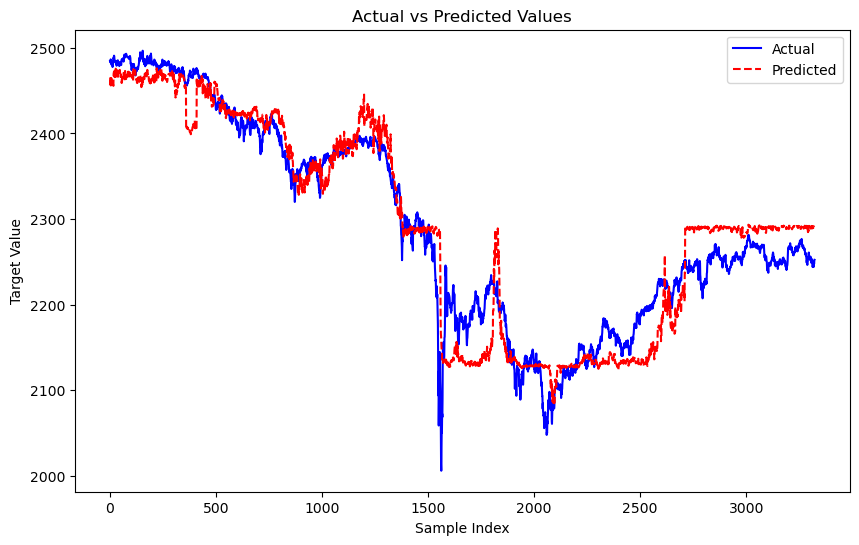

metrics for  lvl -  10 window -  50 no_of_neighbours -  20 ofi -  True


2024-12-07 00:32:05.693018: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 00:32:06.105637: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 1514.4715732654033
R² Score: 0.8939082037516063


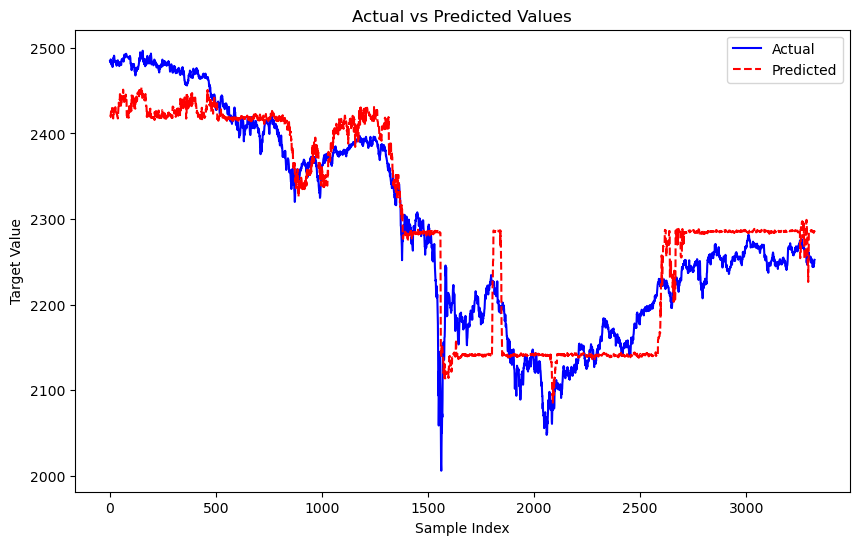

metrics for  lvl -  10 window -  50 no_of_neighbours -  20 ofi -  False


2024-12-07 00:32:10.219911: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 00:32:10.578829: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 1207.0041871373517
R² Score: 0.9154469159057016


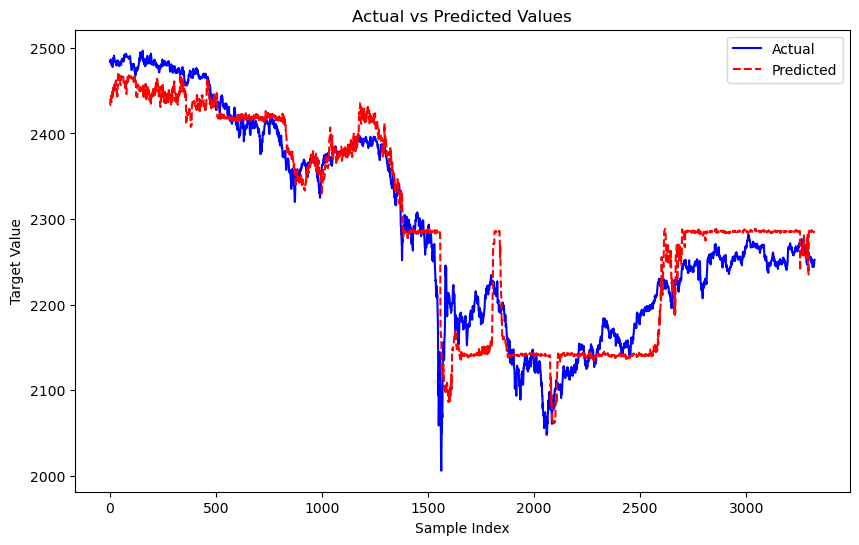

metrics for  lvl -  3 window -  100 no_of_neighbours -  20 ofi -  True


2024-12-07 00:32:13.897419: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 00:32:14.203470: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 1194.651995145245
R² Score: 0.9153847193958048


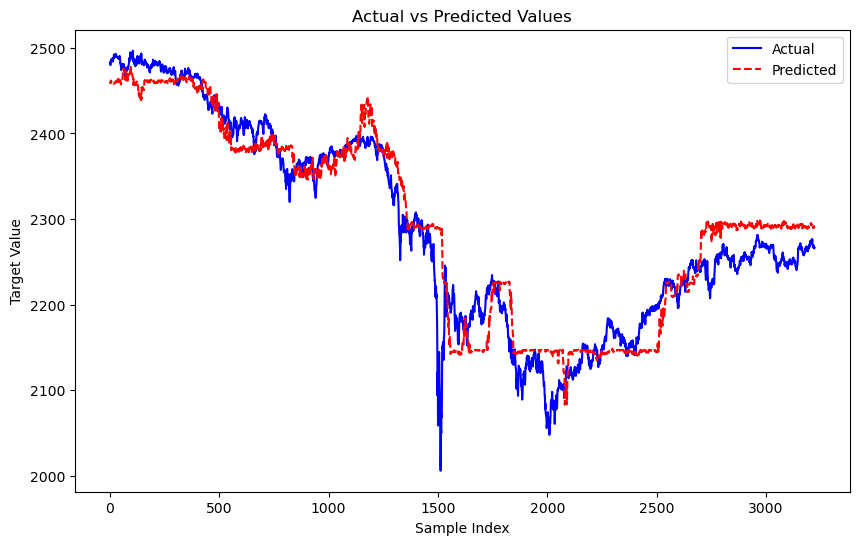

metrics for  lvl -  3 window -  100 no_of_neighbours -  20 ofi -  False


2024-12-07 00:32:16.902072: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 00:32:17.178119: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 1109.1801717306516
R² Score: 0.9214385512659795


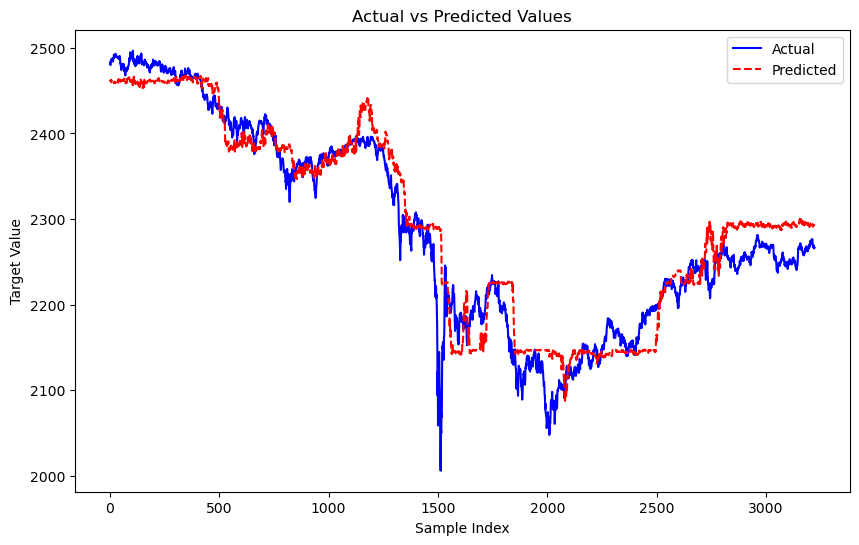

metrics for  lvl -  5 window -  100 no_of_neighbours -  20 ofi -  True


2024-12-07 00:32:19.551850: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 00:32:19.948770: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 1456.9608568475112
R² Score: 0.89680580434096


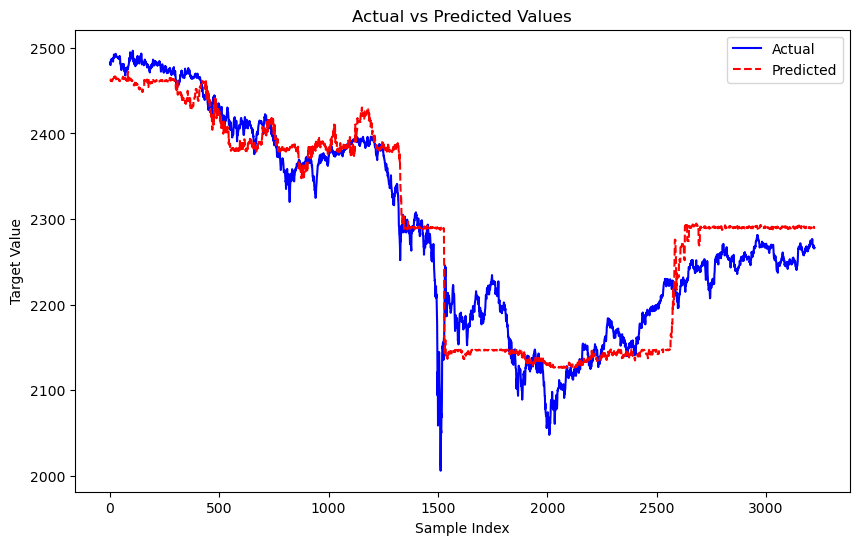

metrics for  lvl -  5 window -  100 no_of_neighbours -  20 ofi -  False


2024-12-07 00:32:23.999591: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 00:32:24.341322: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 1430.6238945510042
R² Score: 0.8986712090479686


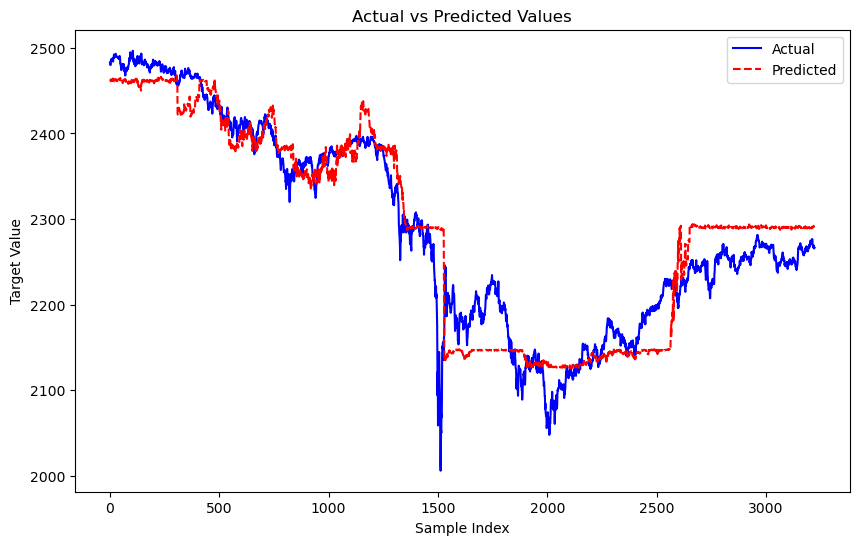

metrics for  lvl -  10 window -  100 no_of_neighbours -  20 ofi -  True


2024-12-07 00:32:27.809871: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 00:32:28.503554: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 1907.2162561395867
R² Score: 0.8649149381226175


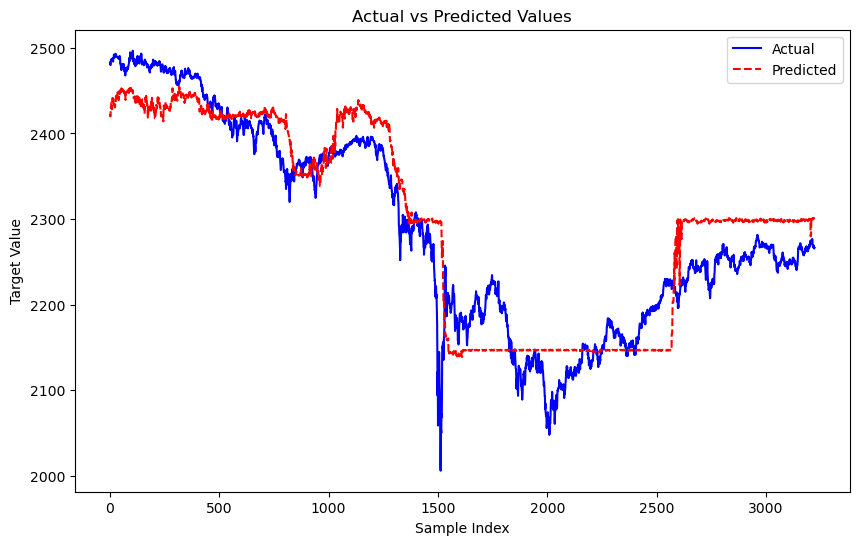

metrics for  lvl -  10 window -  100 no_of_neighbours -  20 ofi -  False


2024-12-07 00:32:35.113889: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 00:32:35.693324: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 1706.5925811875816
R² Score: 0.8791247905490096


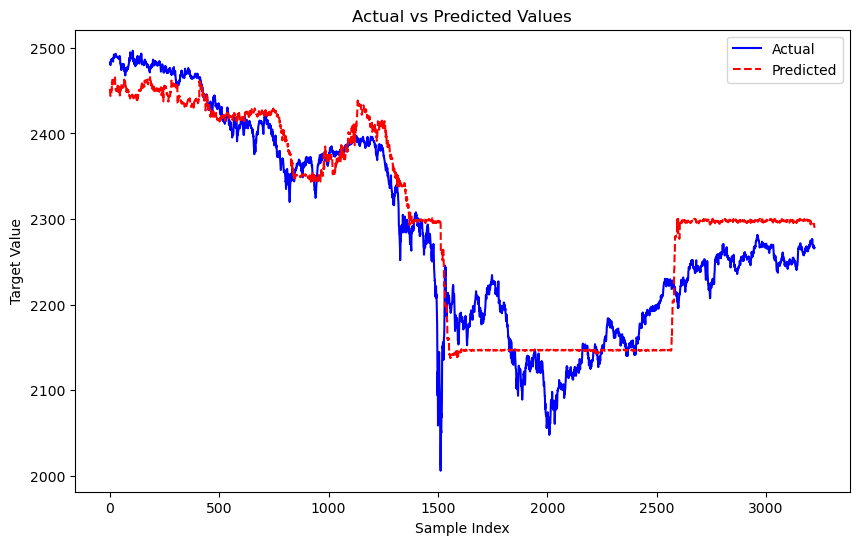

In [6]:
ofi_flag = [True, False]
window_size = [25, 50, 100]
lvls = [3, 5, 10]
neighbours = [5, 10 , 15, 20]

for ng in neighbours:
    for wd in window_size:
        for lvl in lvls:
            for ofi in ofi_flag:
                print("metrics for ", "lvl - ", lvl, "window - ", wd, "no_of_neighbours - ", ng, "ofi - " ,ofi)
                train_model_and_get_result(lvl, wd, ng, ofi)

2024-12-07 00:32:41.152703: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 00:32:41.454096: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 902.6389658427215
R² Score: 0.9370361516943467


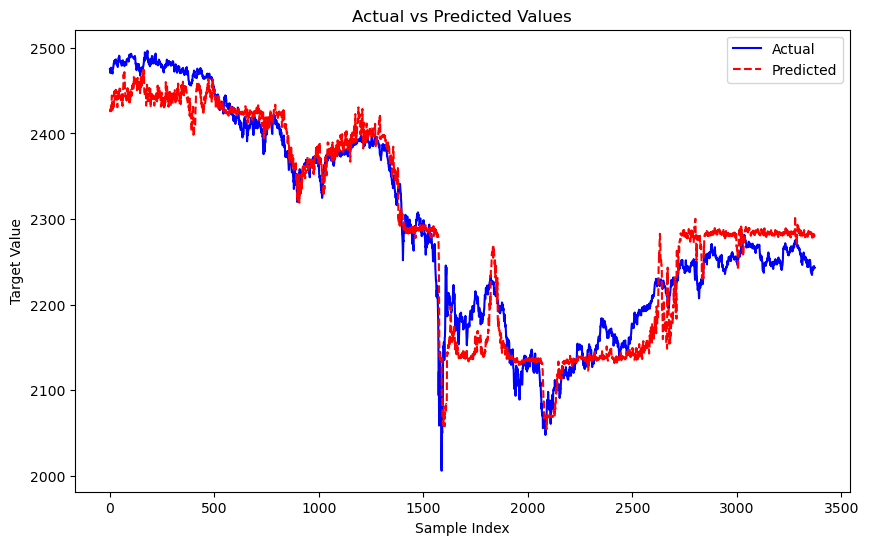

In [7]:
train_model_and_get_result(10, 25, False)

In [8]:
y_pred = knn.predict(X_test_scaled)
dp.get_metrics(y_test, y_pred)

NameError: name 'knn' is not defined

In [ ]:
df_one = dp.get_bid_levels(df, 5)
df_one.head()

df_two = dp.get_bid_with_ofi_levels(df_one, 5)

In [ ]:
# Set window size
window_size = 40

# Drop time column (not needed for input features)
df_two = df_two.drop(columns=["time"])

# Split dataset into train and test sets
data_length = df_two.shape[0]
train_length = round(0.8 * data_length)  # 80% training data
normalized_df = dp.normalize_data(df_two, train_length)

data_array = normalized_df.to_numpy()

X = data_array[:, 1:]  # All columns except the first ('midpoint')
y = df_two["midpoint"]
#y = data_array[:, 0]   # The first column is 'midpoint'

windows_train = timeseries_dataset_from_array(
    X[:train_length],                    # Features for training
    y[window_size:(train_length+window_size)],  # Target (midpoint) for training
    sequence_length=window_size,        # Length of each input sequence
    sequence_stride=1,                  # Step size for creating sequences
    sampling_rate=1,                    # Sample every time step
    batch_size=64,                      # Batch size
    shuffle=False                        # Shuffle training data
)

# Windows for test dataset
windows_test = timeseries_dataset_from_array(
    X[train_length:(data_length-window_size)],  # Features for testing
    y[train_length + window_size:],            # Target (midpoint) for testing
    sequence_length=window_size,               # Length of each input sequence
    sequence_stride=1,                         # Step size for creating sequences
    sampling_rate=1,                           # Sample every time step
    batch_size=64,                             # Batch size
    shuffle=False                              # Do not shuffle test data
)

In [ ]:
import numpy as np

# Extract training data
X_train, y_train = dp.extract_data_from_dataset(windows_train)

# Extract testing data
X_test, y_test = dp.extract_data_from_dataset(windows_test)


In [ ]:
from sklearn.preprocessing import StandardScaler
# Flatten training and testing data
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Flatten each window
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Initialize scaler
scaler = StandardScaler()

# Fit and transform training data
X_train_scaled = scaler.fit_transform(X_train_flat)

# Transform testing data
X_test_scaled = scaler.transform(X_test_flat)


In [ ]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors=8)

knn.fit(X_train_scaled, y_train)

In [ ]:


# Predict on the test set
y_pred = knn.predict(X_test_scaled)
dp.get_metrics(y_test, y_pred)

In [ ]:
Slides
LOB intro
Data preprocessing and Inputs
Models
Metrics and Results
Novelty



Models
1. Results - different lvls 3, ,5, 10 - with ofi , without ofi
Graph
MSE
R2

Horizon